In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action='ignore')
import pickle
import time

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import sklearn.svm as svm
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization

from xgboost import plot_importance
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'lightgbm'

In [2]:
def seed_everything(seed):
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)

seed_everything(37) # Seed 고정

# Data Load

In [3]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [4]:
sub = pd.read_csv('./sample_submission.csv')

# Data Preprocessing

X

In [25]:
train_010 = train_df[(train_df['LINE']=='T010306') & (train_df['LINE']=='T010305')]
train_050 = train_df[(train_df['LINE']=='T050304') & (train_df['LINE']=='T050307')]
train_100 = train_df[(train_df['LINE']=='T010306') & (train_df['LINE']=='T100304')]

In [27]:
test_010 = test_df[(test_df['LINE']=='T010306') & (test_df['LINE']=='T010305')]
test_050 = test_df[(test_df['LINE']=='T050304') & (test_df['LINE']=='T050307')]
test_100 = test_df[(test_df['LINE']=='T100304') & (test_df['LINE']=='T100304')]

In [5]:
train_y = train_df['Y_Class']

In [6]:
train_x = train_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

범주형 데이터를 수치 데이터로 전환하기 위해 LabelEncoder 활용

In [7]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i]) #원래 column 값을 기준으로 fit.
    train_x[i] = le.transform(train_x[i]) #수치화, 수치로 변형

    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


# Modeling

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    test_size=0.2, 
                                                    stratify=train_y, 
                                                    random_state=37)

param_distribs = {
    'min_child_weight': randint(low = 3, high = 5),
    'min_split_loss': randint(low = 1, high = 3),
    'max_depth': randint(low = 3, high = 6),
    'reg_lambda' : randint(low = 1, high = 2),
    'reg_alpha' : randint(low = 0, high = 1)
}
start = time.time()
xgboost_r = XGBClassifier(seed=37, learning_rate = 0.03).fit(train_x,train_y, early_stopping_rounds=50, eval_metric = 'mlogloss',
                                       eval_set = [(X_test, y_test)])
rand_cv = RandomizedSearchCV(xgboost_r, 
                            param_distributions=param_distribs,
                            cv = 5, 
                            n_iter = 50,
                            scoring = 'f1_macro',
                            n_jobs = 1,
                            verbose=3)
rand_cv.fit(train_x, train_y)
preds = rand_cv.predict(test_x)
end = time.time()
# sub['Y_Class'] = preds
# subto_csv('./t34_XGB_RandomSearchCV.csv', index=False)

print(f'최적 하이퍼 파라미터: {rand_cv.best_params_}')
print(f'최고 예측 정확도: {(rand_cv.best_score_):.4f}')
print(f'time elapsed: {end-start}')

[0]	validation_0-mlogloss:1.06865
[1]	validation_0-mlogloss:1.04012
[2]	validation_0-mlogloss:1.01261
[3]	validation_0-mlogloss:0.98696
[4]	validation_0-mlogloss:0.96170
[5]	validation_0-mlogloss:0.93818
[6]	validation_0-mlogloss:0.91517
[7]	validation_0-mlogloss:0.89371
[8]	validation_0-mlogloss:0.87173
[9]	validation_0-mlogloss:0.85182
[10]	validation_0-mlogloss:0.83195
[11]	validation_0-mlogloss:0.81271
[12]	validation_0-mlogloss:0.79413
[13]	validation_0-mlogloss:0.77721
[14]	validation_0-mlogloss:0.76051
[15]	validation_0-mlogloss:0.74440
[16]	validation_0-mlogloss:0.72880
[17]	validation_0-mlogloss:0.71319
[18]	validation_0-mlogloss:0.69869
[19]	validation_0-mlogloss:0.68480
[20]	validation_0-mlogloss:0.67103
[21]	validation_0-mlogloss:0.65819
[22]	validation_0-mlogloss:0.64530
[23]	validation_0-mlogloss:0.63346
[24]	validation_0-mlogloss:0.62147
[25]	validation_0-mlogloss:0.61005
[26]	validation_0-mlogloss:0.59879
[27]	validation_0-mlogloss:0.58890
[28]	validation_0-mlogloss:0.5

[CV 4/5] END max_depth=4, min_child_weight=3, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.301 total time=   5.4s
[CV 5/5] END max_depth=4, min_child_weight=3, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.293 total time=   5.4s
[CV 1/5] END max_depth=3, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.351 total time=   4.1s
[CV 2/5] END max_depth=3, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.399 total time=   4.3s
[CV 3/5] END max_depth=3, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.367 total time=   4.2s
[CV 4/5] END max_depth=3, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.299 total time=   4.3s
[CV 5/5] END max_depth=3, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.305 total time=   4.3s
[CV 1/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.380 total time=   5.9s
[CV 2/5] END max

[CV 1/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.380 total time=   5.8s
[CV 2/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.471 total time=   6.1s
[CV 3/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.329 total time=   6.0s
[CV 4/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.351 total time=   7.2s
[CV 5/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.309 total time=   7.3s
[CV 1/5] END max_depth=4, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.350 total time=   5.6s
[CV 2/5] END max_depth=4, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.399 total time=   5.6s
[CV 3/5] END max_depth=4, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.348 total time=   5.6s
[CV 4/5] END max

[CV 3/5] END max_depth=3, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.353 total time=   4.5s
[CV 4/5] END max_depth=3, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.326 total time=   4.3s
[CV 5/5] END max_depth=3, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.377 total time=   4.2s
[CV 1/5] END max_depth=5, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.359 total time=   6.0s
[CV 2/5] END max_depth=5, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.495 total time=   6.2s
[CV 3/5] END max_depth=5, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.336 total time=   6.1s
[CV 4/5] END max_depth=5, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.301 total time=   6.3s
[CV 5/5] END max_depth=5, min_child_weight=3, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.289 total time=   6.3s
[CV 1/5] END max

[CV 5/5] END max_depth=5, min_child_weight=4, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.317 total time=   6.2s
[CV 1/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.380 total time=   5.8s
[CV 2/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.471 total time=   6.0s
[CV 3/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.329 total time=   6.0s
[CV 4/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.351 total time=   6.2s
[CV 5/5] END max_depth=5, min_child_weight=4, min_split_loss=1, reg_alpha=0, reg_lambda=1;, score=0.309 total time=   6.2s
[CV 1/5] END max_depth=4, min_child_weight=4, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.350 total time=   5.0s
[CV 2/5] END max_depth=4, min_child_weight=4, min_split_loss=2, reg_alpha=0, reg_lambda=1;, score=0.448 total time=   5.2s
[CV 3/5] END max

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(n_estimators=1500)

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    test_size=0.2, 
                                                    stratify=train_y, 
                                                    random_state=37)

# 후보 파라미터 선정
params = {'max_depth':[4],
          'subsample':[0.5], #일단 1보다 아래이면 좋은지: "좋다" 나중ㅇ에 0.75추가
          'learning_rate':[0.03], #0.01, 0.02, 
          'min_child_weight':[4], #1,2,
          'min_split_loss':[1.1],
          'reg_lambda': [1], 
          'reg_alpha' : [0.2],

           'colsample_bytree':[0.5,0.6, 0.7, 0.8,0.9]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb_model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(train_x, train_y, early_stopping_rounds=50, eval_metric='mlogloss', eval_set=[(X_train, y_train), (X_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)
print(gridcv.best_score_)

[0]	validation_0-mlogloss:1.07976	validation_1-mlogloss:1.08113
[1]	validation_0-mlogloss:1.06255	validation_1-mlogloss:1.06327
[2]	validation_0-mlogloss:1.04493	validation_1-mlogloss:1.04541
[3]	validation_0-mlogloss:1.02959	validation_1-mlogloss:1.03168
[4]	validation_0-mlogloss:1.01286	validation_1-mlogloss:1.01730
[5]	validation_0-mlogloss:0.99684	validation_1-mlogloss:1.00195
[6]	validation_0-mlogloss:0.98361	validation_1-mlogloss:0.99196
[7]	validation_0-mlogloss:0.96941	validation_1-mlogloss:0.97835
[8]	validation_0-mlogloss:0.95512	validation_1-mlogloss:0.96565
[9]	validation_0-mlogloss:0.94256	validation_1-mlogloss:0.95468
[10]	validation_0-mlogloss:0.92852	validation_1-mlogloss:0.93966
[11]	validation_0-mlogloss:0.91543	validation_1-mlogloss:0.92697
[12]	validation_0-mlogloss:0.90350	validation_1-mlogloss:0.91667
[13]	validation_0-mlogloss:0.89172	validation_1-mlogloss:0.90518
[14]	validation_0-mlogloss:0.88063	validation_1-mlogloss:0.89463
[15]	validation_0-mlogloss:0.87146	

[126]	validation_0-mlogloss:0.51220	validation_1-mlogloss:0.54481
[127]	validation_0-mlogloss:0.51124	validation_1-mlogloss:0.54418
[128]	validation_0-mlogloss:0.51036	validation_1-mlogloss:0.54351
[129]	validation_0-mlogloss:0.50942	validation_1-mlogloss:0.54287
[130]	validation_0-mlogloss:0.50874	validation_1-mlogloss:0.54206
[131]	validation_0-mlogloss:0.50758	validation_1-mlogloss:0.54105
[132]	validation_0-mlogloss:0.50670	validation_1-mlogloss:0.54068
[133]	validation_0-mlogloss:0.50577	validation_1-mlogloss:0.54029
[134]	validation_0-mlogloss:0.50528	validation_1-mlogloss:0.54044
[135]	validation_0-mlogloss:0.50429	validation_1-mlogloss:0.54026
[136]	validation_0-mlogloss:0.50327	validation_1-mlogloss:0.53935
[137]	validation_0-mlogloss:0.50226	validation_1-mlogloss:0.53865
[138]	validation_0-mlogloss:0.50109	validation_1-mlogloss:0.53862
[139]	validation_0-mlogloss:0.50026	validation_1-mlogloss:0.53844
[140]	validation_0-mlogloss:0.49911	validation_1-mlogloss:0.53848
[141]	vali

[251]	validation_0-mlogloss:0.42961	validation_1-mlogloss:0.49310
[252]	validation_0-mlogloss:0.42970	validation_1-mlogloss:0.49298
[253]	validation_0-mlogloss:0.42963	validation_1-mlogloss:0.49313
[254]	validation_0-mlogloss:0.42937	validation_1-mlogloss:0.49284
[255]	validation_0-mlogloss:0.42934	validation_1-mlogloss:0.49302
[256]	validation_0-mlogloss:0.42902	validation_1-mlogloss:0.49243
[257]	validation_0-mlogloss:0.42921	validation_1-mlogloss:0.49200
[258]	validation_0-mlogloss:0.42816	validation_1-mlogloss:0.49080
[259]	validation_0-mlogloss:0.42767	validation_1-mlogloss:0.49107
[260]	validation_0-mlogloss:0.42746	validation_1-mlogloss:0.49117
[261]	validation_0-mlogloss:0.42716	validation_1-mlogloss:0.49079
[262]	validation_0-mlogloss:0.42689	validation_1-mlogloss:0.49067
[263]	validation_0-mlogloss:0.42653	validation_1-mlogloss:0.49061
[264]	validation_0-mlogloss:0.42630	validation_1-mlogloss:0.49004
[265]	validation_0-mlogloss:0.42629	validation_1-mlogloss:0.48998
[266]	vali

[376]	validation_0-mlogloss:0.40912	validation_1-mlogloss:0.47657
[377]	validation_0-mlogloss:0.40908	validation_1-mlogloss:0.47650
[378]	validation_0-mlogloss:0.40872	validation_1-mlogloss:0.47627
[379]	validation_0-mlogloss:0.40850	validation_1-mlogloss:0.47621
[380]	validation_0-mlogloss:0.40805	validation_1-mlogloss:0.47589
[381]	validation_0-mlogloss:0.40811	validation_1-mlogloss:0.47521
[382]	validation_0-mlogloss:0.40805	validation_1-mlogloss:0.47515
[383]	validation_0-mlogloss:0.40817	validation_1-mlogloss:0.47519
[384]	validation_0-mlogloss:0.40825	validation_1-mlogloss:0.47517
[385]	validation_0-mlogloss:0.40803	validation_1-mlogloss:0.47455
[386]	validation_0-mlogloss:0.40791	validation_1-mlogloss:0.47475
[387]	validation_0-mlogloss:0.40816	validation_1-mlogloss:0.47498
[388]	validation_0-mlogloss:0.40780	validation_1-mlogloss:0.47453
[389]	validation_0-mlogloss:0.40771	validation_1-mlogloss:0.47434
[390]	validation_0-mlogloss:0.40757	validation_1-mlogloss:0.47428
[391]	vali

[501]	validation_0-mlogloss:0.40218	validation_1-mlogloss:0.47069
[502]	validation_0-mlogloss:0.40227	validation_1-mlogloss:0.47083
[503]	validation_0-mlogloss:0.40214	validation_1-mlogloss:0.47062
[504]	validation_0-mlogloss:0.40223	validation_1-mlogloss:0.47066
[505]	validation_0-mlogloss:0.40221	validation_1-mlogloss:0.47061
[506]	validation_0-mlogloss:0.40230	validation_1-mlogloss:0.47077
[507]	validation_0-mlogloss:0.40247	validation_1-mlogloss:0.47124
[508]	validation_0-mlogloss:0.40243	validation_1-mlogloss:0.47118
[509]	validation_0-mlogloss:0.40241	validation_1-mlogloss:0.47127
[510]	validation_0-mlogloss:0.40235	validation_1-mlogloss:0.47122
[511]	validation_0-mlogloss:0.40229	validation_1-mlogloss:0.47117
[512]	validation_0-mlogloss:0.40228	validation_1-mlogloss:0.47114
[513]	validation_0-mlogloss:0.40225	validation_1-mlogloss:0.47102
[514]	validation_0-mlogloss:0.40214	validation_1-mlogloss:0.47083
[515]	validation_0-mlogloss:0.40213	validation_1-mlogloss:0.47082
[516]	vali

[626]	validation_0-mlogloss:0.39838	validation_1-mlogloss:0.46717
[627]	validation_0-mlogloss:0.39859	validation_1-mlogloss:0.46796
[628]	validation_0-mlogloss:0.39861	validation_1-mlogloss:0.46799
[629]	validation_0-mlogloss:0.39853	validation_1-mlogloss:0.46809
[630]	validation_0-mlogloss:0.39855	validation_1-mlogloss:0.46810
[631]	validation_0-mlogloss:0.39857	validation_1-mlogloss:0.46813
[632]	validation_0-mlogloss:0.39852	validation_1-mlogloss:0.46805
[633]	validation_0-mlogloss:0.39858	validation_1-mlogloss:0.46816
[634]	validation_0-mlogloss:0.39863	validation_1-mlogloss:0.46824
[635]	validation_0-mlogloss:0.39865	validation_1-mlogloss:0.46826
[636]	validation_0-mlogloss:0.39864	validation_1-mlogloss:0.46823
[637]	validation_0-mlogloss:0.39868	validation_1-mlogloss:0.46837
[638]	validation_0-mlogloss:0.39863	validation_1-mlogloss:0.46832
[639]	validation_0-mlogloss:0.39873	validation_1-mlogloss:0.46842
[640]	validation_0-mlogloss:0.39874	validation_1-mlogloss:0.46841
[641]	vali

[77]	validation_0-mlogloss:0.57959	validation_1-mlogloss:0.54277
[78]	validation_0-mlogloss:0.57791	validation_1-mlogloss:0.53989
[79]	validation_0-mlogloss:0.57589	validation_1-mlogloss:0.53726
[80]	validation_0-mlogloss:0.57428	validation_1-mlogloss:0.53517
[81]	validation_0-mlogloss:0.57206	validation_1-mlogloss:0.53297
[82]	validation_0-mlogloss:0.56894	validation_1-mlogloss:0.53040
[83]	validation_0-mlogloss:0.56664	validation_1-mlogloss:0.52767
[84]	validation_0-mlogloss:0.56503	validation_1-mlogloss:0.52631
[85]	validation_0-mlogloss:0.56298	validation_1-mlogloss:0.52450
[86]	validation_0-mlogloss:0.56133	validation_1-mlogloss:0.52172
[87]	validation_0-mlogloss:0.56003	validation_1-mlogloss:0.52010
[88]	validation_0-mlogloss:0.55819	validation_1-mlogloss:0.51781
[89]	validation_0-mlogloss:0.55581	validation_1-mlogloss:0.51583
[90]	validation_0-mlogloss:0.55440	validation_1-mlogloss:0.51396
[91]	validation_0-mlogloss:0.55241	validation_1-mlogloss:0.51120
[92]	validation_0-mloglos

[202]	validation_0-mlogloss:0.45050	validation_1-mlogloss:0.39338
[203]	validation_0-mlogloss:0.44989	validation_1-mlogloss:0.39302
[204]	validation_0-mlogloss:0.44978	validation_1-mlogloss:0.39207
[205]	validation_0-mlogloss:0.44926	validation_1-mlogloss:0.39195
[206]	validation_0-mlogloss:0.44892	validation_1-mlogloss:0.39134
[207]	validation_0-mlogloss:0.44806	validation_1-mlogloss:0.39074
[208]	validation_0-mlogloss:0.44765	validation_1-mlogloss:0.39023
[209]	validation_0-mlogloss:0.44701	validation_1-mlogloss:0.38959
[210]	validation_0-mlogloss:0.44633	validation_1-mlogloss:0.38926
[211]	validation_0-mlogloss:0.44571	validation_1-mlogloss:0.38912
[212]	validation_0-mlogloss:0.44501	validation_1-mlogloss:0.38816
[213]	validation_0-mlogloss:0.44481	validation_1-mlogloss:0.38795
[214]	validation_0-mlogloss:0.44438	validation_1-mlogloss:0.38714
[215]	validation_0-mlogloss:0.44378	validation_1-mlogloss:0.38690
[216]	validation_0-mlogloss:0.44339	validation_1-mlogloss:0.38677
[217]	vali

[327]	validation_0-mlogloss:0.41584	validation_1-mlogloss:0.35939
[328]	validation_0-mlogloss:0.41581	validation_1-mlogloss:0.35934
[329]	validation_0-mlogloss:0.41550	validation_1-mlogloss:0.35906
[330]	validation_0-mlogloss:0.41528	validation_1-mlogloss:0.35916
[331]	validation_0-mlogloss:0.41507	validation_1-mlogloss:0.35888
[332]	validation_0-mlogloss:0.41496	validation_1-mlogloss:0.35884
[333]	validation_0-mlogloss:0.41475	validation_1-mlogloss:0.35867
[334]	validation_0-mlogloss:0.41476	validation_1-mlogloss:0.35866
[335]	validation_0-mlogloss:0.41460	validation_1-mlogloss:0.35871
[336]	validation_0-mlogloss:0.41472	validation_1-mlogloss:0.35860
[337]	validation_0-mlogloss:0.41467	validation_1-mlogloss:0.35874
[338]	validation_0-mlogloss:0.41433	validation_1-mlogloss:0.35810
[339]	validation_0-mlogloss:0.41436	validation_1-mlogloss:0.35809
[340]	validation_0-mlogloss:0.41437	validation_1-mlogloss:0.35813
[341]	validation_0-mlogloss:0.41443	validation_1-mlogloss:0.35834
[342]	vali

[452]	validation_0-mlogloss:0.40734	validation_1-mlogloss:0.35220
[453]	validation_0-mlogloss:0.40716	validation_1-mlogloss:0.35221
[454]	validation_0-mlogloss:0.40693	validation_1-mlogloss:0.35208
[455]	validation_0-mlogloss:0.40680	validation_1-mlogloss:0.35189
[456]	validation_0-mlogloss:0.40652	validation_1-mlogloss:0.35150
[457]	validation_0-mlogloss:0.40655	validation_1-mlogloss:0.35160
[458]	validation_0-mlogloss:0.40619	validation_1-mlogloss:0.35111
[459]	validation_0-mlogloss:0.40620	validation_1-mlogloss:0.35098
[460]	validation_0-mlogloss:0.40618	validation_1-mlogloss:0.35098
[461]	validation_0-mlogloss:0.40617	validation_1-mlogloss:0.35104
[462]	validation_0-mlogloss:0.40620	validation_1-mlogloss:0.35127
[463]	validation_0-mlogloss:0.40626	validation_1-mlogloss:0.35093
[464]	validation_0-mlogloss:0.40620	validation_1-mlogloss:0.35092
[465]	validation_0-mlogloss:0.40596	validation_1-mlogloss:0.35087
[466]	validation_0-mlogloss:0.40576	validation_1-mlogloss:0.35025
[467]	vali

[577]	validation_0-mlogloss:0.40446	validation_1-mlogloss:0.34714
[578]	validation_0-mlogloss:0.40432	validation_1-mlogloss:0.34709
[579]	validation_0-mlogloss:0.40434	validation_1-mlogloss:0.34709
[580]	validation_0-mlogloss:0.40396	validation_1-mlogloss:0.34677
[581]	validation_0-mlogloss:0.40402	validation_1-mlogloss:0.34696
[582]	validation_0-mlogloss:0.40403	validation_1-mlogloss:0.34696
[583]	validation_0-mlogloss:0.40403	validation_1-mlogloss:0.34696
[584]	validation_0-mlogloss:0.40402	validation_1-mlogloss:0.34695
[585]	validation_0-mlogloss:0.40406	validation_1-mlogloss:0.34696
[586]	validation_0-mlogloss:0.40382	validation_1-mlogloss:0.34716
[587]	validation_0-mlogloss:0.40385	validation_1-mlogloss:0.34717
[588]	validation_0-mlogloss:0.40382	validation_1-mlogloss:0.34716
[589]	validation_0-mlogloss:0.40389	validation_1-mlogloss:0.34717
[590]	validation_0-mlogloss:0.40391	validation_1-mlogloss:0.34696
[591]	validation_0-mlogloss:0.40393	validation_1-mlogloss:0.34697
[592]	vali

[702]	validation_0-mlogloss:0.40245	validation_1-mlogloss:0.34463
[703]	validation_0-mlogloss:0.40245	validation_1-mlogloss:0.34463
[704]	validation_0-mlogloss:0.40248	validation_1-mlogloss:0.34464
[705]	validation_0-mlogloss:0.40251	validation_1-mlogloss:0.34472
[706]	validation_0-mlogloss:0.40249	validation_1-mlogloss:0.34472
[707]	validation_0-mlogloss:0.40248	validation_1-mlogloss:0.34472
[708]	validation_0-mlogloss:0.40240	validation_1-mlogloss:0.34474
[709]	validation_0-mlogloss:0.40216	validation_1-mlogloss:0.34452
[710]	validation_0-mlogloss:0.40209	validation_1-mlogloss:0.34446
[0]	validation_0-mlogloss:1.07767	validation_1-mlogloss:1.07769
[1]	validation_0-mlogloss:1.05821	validation_1-mlogloss:1.05758
[2]	validation_0-mlogloss:1.03913	validation_1-mlogloss:1.03826
[3]	validation_0-mlogloss:1.02115	validation_1-mlogloss:1.01976
[4]	validation_0-mlogloss:1.00475	validation_1-mlogloss:1.00391
[5]	validation_0-mlogloss:0.98863	validation_1-mlogloss:0.98698
[6]	validation_0-mlogl

[117]	validation_0-mlogloss:0.51814	validation_1-mlogloss:0.49388
[118]	validation_0-mlogloss:0.51715	validation_1-mlogloss:0.49378
[119]	validation_0-mlogloss:0.51625	validation_1-mlogloss:0.49333
[120]	validation_0-mlogloss:0.51511	validation_1-mlogloss:0.49228
[121]	validation_0-mlogloss:0.51375	validation_1-mlogloss:0.49114
[122]	validation_0-mlogloss:0.51227	validation_1-mlogloss:0.49066
[123]	validation_0-mlogloss:0.51149	validation_1-mlogloss:0.49006
[124]	validation_0-mlogloss:0.51106	validation_1-mlogloss:0.48887
[125]	validation_0-mlogloss:0.51005	validation_1-mlogloss:0.48809
[126]	validation_0-mlogloss:0.50953	validation_1-mlogloss:0.48693
[127]	validation_0-mlogloss:0.50834	validation_1-mlogloss:0.48591
[128]	validation_0-mlogloss:0.50711	validation_1-mlogloss:0.48486
[129]	validation_0-mlogloss:0.50617	validation_1-mlogloss:0.48425
[130]	validation_0-mlogloss:0.50473	validation_1-mlogloss:0.48343
[131]	validation_0-mlogloss:0.50381	validation_1-mlogloss:0.48278
[132]	vali

[242]	validation_0-mlogloss:0.44537	validation_1-mlogloss:0.41404
[243]	validation_0-mlogloss:0.44496	validation_1-mlogloss:0.41324
[244]	validation_0-mlogloss:0.44490	validation_1-mlogloss:0.41283
[245]	validation_0-mlogloss:0.44487	validation_1-mlogloss:0.41266
[246]	validation_0-mlogloss:0.44461	validation_1-mlogloss:0.41263
[247]	validation_0-mlogloss:0.44452	validation_1-mlogloss:0.41314
[248]	validation_0-mlogloss:0.44435	validation_1-mlogloss:0.41325
[249]	validation_0-mlogloss:0.44424	validation_1-mlogloss:0.41339
[250]	validation_0-mlogloss:0.44413	validation_1-mlogloss:0.41329
[251]	validation_0-mlogloss:0.44355	validation_1-mlogloss:0.41279
[252]	validation_0-mlogloss:0.44342	validation_1-mlogloss:0.41223
[253]	validation_0-mlogloss:0.44302	validation_1-mlogloss:0.41212
[254]	validation_0-mlogloss:0.44290	validation_1-mlogloss:0.41215
[255]	validation_0-mlogloss:0.44251	validation_1-mlogloss:0.41168
[256]	validation_0-mlogloss:0.44249	validation_1-mlogloss:0.41150
[257]	vali

[367]	validation_0-mlogloss:0.42845	validation_1-mlogloss:0.39547
[368]	validation_0-mlogloss:0.42824	validation_1-mlogloss:0.39524
[369]	validation_0-mlogloss:0.42803	validation_1-mlogloss:0.39496
[370]	validation_0-mlogloss:0.42802	validation_1-mlogloss:0.39504
[371]	validation_0-mlogloss:0.42806	validation_1-mlogloss:0.39502
[372]	validation_0-mlogloss:0.42804	validation_1-mlogloss:0.39510
[373]	validation_0-mlogloss:0.42800	validation_1-mlogloss:0.39514
[374]	validation_0-mlogloss:0.42797	validation_1-mlogloss:0.39487
[375]	validation_0-mlogloss:0.42799	validation_1-mlogloss:0.39476
[376]	validation_0-mlogloss:0.42796	validation_1-mlogloss:0.39431
[377]	validation_0-mlogloss:0.42784	validation_1-mlogloss:0.39431
[378]	validation_0-mlogloss:0.42776	validation_1-mlogloss:0.39427
[379]	validation_0-mlogloss:0.42767	validation_1-mlogloss:0.39440
[380]	validation_0-mlogloss:0.42766	validation_1-mlogloss:0.39433
[381]	validation_0-mlogloss:0.42758	validation_1-mlogloss:0.39416
[382]	vali

[34]	validation_0-mlogloss:0.71982	validation_1-mlogloss:0.73827
[35]	validation_0-mlogloss:0.71484	validation_1-mlogloss:0.73318
[36]	validation_0-mlogloss:0.70965	validation_1-mlogloss:0.72786
[37]	validation_0-mlogloss:0.70506	validation_1-mlogloss:0.72362
[38]	validation_0-mlogloss:0.69973	validation_1-mlogloss:0.71751
[39]	validation_0-mlogloss:0.69597	validation_1-mlogloss:0.71306
[40]	validation_0-mlogloss:0.69160	validation_1-mlogloss:0.70839
[41]	validation_0-mlogloss:0.68835	validation_1-mlogloss:0.70449
[42]	validation_0-mlogloss:0.68315	validation_1-mlogloss:0.70098
[43]	validation_0-mlogloss:0.67858	validation_1-mlogloss:0.69624
[44]	validation_0-mlogloss:0.67412	validation_1-mlogloss:0.69268
[45]	validation_0-mlogloss:0.66941	validation_1-mlogloss:0.68865
[46]	validation_0-mlogloss:0.66561	validation_1-mlogloss:0.68470
[47]	validation_0-mlogloss:0.66143	validation_1-mlogloss:0.68016
[48]	validation_0-mlogloss:0.65725	validation_1-mlogloss:0.67646
[49]	validation_0-mloglos

[160]	validation_0-mlogloss:0.47176	validation_1-mlogloss:0.51851
[161]	validation_0-mlogloss:0.47151	validation_1-mlogloss:0.51869
[162]	validation_0-mlogloss:0.47083	validation_1-mlogloss:0.51801
[163]	validation_0-mlogloss:0.47030	validation_1-mlogloss:0.51767
[164]	validation_0-mlogloss:0.46925	validation_1-mlogloss:0.51716
[165]	validation_0-mlogloss:0.46819	validation_1-mlogloss:0.51670
[166]	validation_0-mlogloss:0.46756	validation_1-mlogloss:0.51617
[167]	validation_0-mlogloss:0.46644	validation_1-mlogloss:0.51516
[168]	validation_0-mlogloss:0.46593	validation_1-mlogloss:0.51533
[169]	validation_0-mlogloss:0.46554	validation_1-mlogloss:0.51491
[170]	validation_0-mlogloss:0.46488	validation_1-mlogloss:0.51382
[171]	validation_0-mlogloss:0.46398	validation_1-mlogloss:0.51353
[172]	validation_0-mlogloss:0.46310	validation_1-mlogloss:0.51291
[173]	validation_0-mlogloss:0.46174	validation_1-mlogloss:0.51245
[174]	validation_0-mlogloss:0.46079	validation_1-mlogloss:0.51236
[175]	vali

[285]	validation_0-mlogloss:0.41745	validation_1-mlogloss:0.48018
[286]	validation_0-mlogloss:0.41731	validation_1-mlogloss:0.47966
[287]	validation_0-mlogloss:0.41710	validation_1-mlogloss:0.47980
[288]	validation_0-mlogloss:0.41692	validation_1-mlogloss:0.47996
[289]	validation_0-mlogloss:0.41660	validation_1-mlogloss:0.47939
[290]	validation_0-mlogloss:0.41647	validation_1-mlogloss:0.47982
[291]	validation_0-mlogloss:0.41624	validation_1-mlogloss:0.47940
[292]	validation_0-mlogloss:0.41612	validation_1-mlogloss:0.47957
[293]	validation_0-mlogloss:0.41577	validation_1-mlogloss:0.47873
[294]	validation_0-mlogloss:0.41550	validation_1-mlogloss:0.47901
[295]	validation_0-mlogloss:0.41505	validation_1-mlogloss:0.47839
[296]	validation_0-mlogloss:0.41515	validation_1-mlogloss:0.47831
[297]	validation_0-mlogloss:0.41495	validation_1-mlogloss:0.47864
[298]	validation_0-mlogloss:0.41485	validation_1-mlogloss:0.47851
[299]	validation_0-mlogloss:0.41507	validation_1-mlogloss:0.47873
[300]	vali

[410]	validation_0-mlogloss:0.40558	validation_1-mlogloss:0.47276
[411]	validation_0-mlogloss:0.40570	validation_1-mlogloss:0.47301
[412]	validation_0-mlogloss:0.40581	validation_1-mlogloss:0.47299
[413]	validation_0-mlogloss:0.40579	validation_1-mlogloss:0.47297
[414]	validation_0-mlogloss:0.40574	validation_1-mlogloss:0.47235
[415]	validation_0-mlogloss:0.40567	validation_1-mlogloss:0.47236
[416]	validation_0-mlogloss:0.40569	validation_1-mlogloss:0.47241
[417]	validation_0-mlogloss:0.40536	validation_1-mlogloss:0.47189
[418]	validation_0-mlogloss:0.40505	validation_1-mlogloss:0.47163
[419]	validation_0-mlogloss:0.40497	validation_1-mlogloss:0.47152
[420]	validation_0-mlogloss:0.40502	validation_1-mlogloss:0.47172
[421]	validation_0-mlogloss:0.40489	validation_1-mlogloss:0.47181
[422]	validation_0-mlogloss:0.40485	validation_1-mlogloss:0.47140
[423]	validation_0-mlogloss:0.40492	validation_1-mlogloss:0.47148
[424]	validation_0-mlogloss:0.40485	validation_1-mlogloss:0.47138
[425]	vali

[535]	validation_0-mlogloss:0.39980	validation_1-mlogloss:0.46874
[536]	validation_0-mlogloss:0.39967	validation_1-mlogloss:0.46895
[537]	validation_0-mlogloss:0.39972	validation_1-mlogloss:0.46901
[538]	validation_0-mlogloss:0.39982	validation_1-mlogloss:0.46905
[539]	validation_0-mlogloss:0.39981	validation_1-mlogloss:0.46905
[540]	validation_0-mlogloss:0.39978	validation_1-mlogloss:0.46915
[541]	validation_0-mlogloss:0.39966	validation_1-mlogloss:0.46902
[542]	validation_0-mlogloss:0.39966	validation_1-mlogloss:0.46901
[543]	validation_0-mlogloss:0.39968	validation_1-mlogloss:0.46903
[544]	validation_0-mlogloss:0.39935	validation_1-mlogloss:0.46875
[545]	validation_0-mlogloss:0.39939	validation_1-mlogloss:0.46878
[546]	validation_0-mlogloss:0.39924	validation_1-mlogloss:0.46854
[547]	validation_0-mlogloss:0.39928	validation_1-mlogloss:0.46855
[548]	validation_0-mlogloss:0.39924	validation_1-mlogloss:0.46846
[549]	validation_0-mlogloss:0.39928	validation_1-mlogloss:0.46853
[550]	vali

[660]	validation_0-mlogloss:0.39642	validation_1-mlogloss:0.46685
[661]	validation_0-mlogloss:0.39650	validation_1-mlogloss:0.46697
[662]	validation_0-mlogloss:0.39654	validation_1-mlogloss:0.46697
[663]	validation_0-mlogloss:0.39663	validation_1-mlogloss:0.46717
[664]	validation_0-mlogloss:0.39661	validation_1-mlogloss:0.46707
[665]	validation_0-mlogloss:0.39659	validation_1-mlogloss:0.46706
[666]	validation_0-mlogloss:0.39664	validation_1-mlogloss:0.46714
[667]	validation_0-mlogloss:0.39661	validation_1-mlogloss:0.46707
[668]	validation_0-mlogloss:0.39658	validation_1-mlogloss:0.46703
[669]	validation_0-mlogloss:0.39655	validation_1-mlogloss:0.46698
[670]	validation_0-mlogloss:0.39654	validation_1-mlogloss:0.46696
[671]	validation_0-mlogloss:0.39661	validation_1-mlogloss:0.46705
[672]	validation_0-mlogloss:0.39661	validation_1-mlogloss:0.46707
[673]	validation_0-mlogloss:0.39637	validation_1-mlogloss:0.46662
[0]	validation_0-mlogloss:1.07905	validation_1-mlogloss:1.07852
[1]	validati

[112]	validation_0-mlogloss:0.52094	validation_1-mlogloss:0.47425
[113]	validation_0-mlogloss:0.51980	validation_1-mlogloss:0.47291
[114]	validation_0-mlogloss:0.51869	validation_1-mlogloss:0.47076
[115]	validation_0-mlogloss:0.51707	validation_1-mlogloss:0.46870
[116]	validation_0-mlogloss:0.51595	validation_1-mlogloss:0.46746
[117]	validation_0-mlogloss:0.51488	validation_1-mlogloss:0.46699
[118]	validation_0-mlogloss:0.51351	validation_1-mlogloss:0.46572
[119]	validation_0-mlogloss:0.51267	validation_1-mlogloss:0.46400
[120]	validation_0-mlogloss:0.51118	validation_1-mlogloss:0.46164
[121]	validation_0-mlogloss:0.50979	validation_1-mlogloss:0.46007
[122]	validation_0-mlogloss:0.50858	validation_1-mlogloss:0.45863
[123]	validation_0-mlogloss:0.50757	validation_1-mlogloss:0.45643
[124]	validation_0-mlogloss:0.50636	validation_1-mlogloss:0.45521
[125]	validation_0-mlogloss:0.50496	validation_1-mlogloss:0.45302
[126]	validation_0-mlogloss:0.50400	validation_1-mlogloss:0.45242
[127]	vali

[237]	validation_0-mlogloss:0.43274	validation_1-mlogloss:0.37675
[238]	validation_0-mlogloss:0.43270	validation_1-mlogloss:0.37697
[239]	validation_0-mlogloss:0.43252	validation_1-mlogloss:0.37699
[240]	validation_0-mlogloss:0.43214	validation_1-mlogloss:0.37704
[241]	validation_0-mlogloss:0.43202	validation_1-mlogloss:0.37704
[242]	validation_0-mlogloss:0.43101	validation_1-mlogloss:0.37591
[243]	validation_0-mlogloss:0.43068	validation_1-mlogloss:0.37538
[244]	validation_0-mlogloss:0.43046	validation_1-mlogloss:0.37493
[245]	validation_0-mlogloss:0.42991	validation_1-mlogloss:0.37424
[246]	validation_0-mlogloss:0.42933	validation_1-mlogloss:0.37355
[247]	validation_0-mlogloss:0.42901	validation_1-mlogloss:0.37331
[248]	validation_0-mlogloss:0.42841	validation_1-mlogloss:0.37301
[249]	validation_0-mlogloss:0.42844	validation_1-mlogloss:0.37308
[250]	validation_0-mlogloss:0.42764	validation_1-mlogloss:0.37204
[251]	validation_0-mlogloss:0.42716	validation_1-mlogloss:0.37204
[252]	vali

[362]	validation_0-mlogloss:0.40982	validation_1-mlogloss:0.35632
[363]	validation_0-mlogloss:0.40994	validation_1-mlogloss:0.35624
[364]	validation_0-mlogloss:0.40998	validation_1-mlogloss:0.35627
[365]	validation_0-mlogloss:0.40996	validation_1-mlogloss:0.35619
[366]	validation_0-mlogloss:0.41003	validation_1-mlogloss:0.35575
[367]	validation_0-mlogloss:0.41000	validation_1-mlogloss:0.35541
[368]	validation_0-mlogloss:0.40993	validation_1-mlogloss:0.35542
[369]	validation_0-mlogloss:0.40972	validation_1-mlogloss:0.35511
[370]	validation_0-mlogloss:0.40963	validation_1-mlogloss:0.35513
[371]	validation_0-mlogloss:0.40961	validation_1-mlogloss:0.35513
[372]	validation_0-mlogloss:0.40956	validation_1-mlogloss:0.35502
[373]	validation_0-mlogloss:0.40955	validation_1-mlogloss:0.35486
[374]	validation_0-mlogloss:0.40934	validation_1-mlogloss:0.35475
[375]	validation_0-mlogloss:0.40897	validation_1-mlogloss:0.35431
[376]	validation_0-mlogloss:0.40923	validation_1-mlogloss:0.35467
[377]	vali

[487]	validation_0-mlogloss:0.40469	validation_1-mlogloss:0.34958
[488]	validation_0-mlogloss:0.40480	validation_1-mlogloss:0.34948
[489]	validation_0-mlogloss:0.40481	validation_1-mlogloss:0.34948
[490]	validation_0-mlogloss:0.40446	validation_1-mlogloss:0.34927
[491]	validation_0-mlogloss:0.40446	validation_1-mlogloss:0.34927
[492]	validation_0-mlogloss:0.40443	validation_1-mlogloss:0.34900
[493]	validation_0-mlogloss:0.40442	validation_1-mlogloss:0.34901
[494]	validation_0-mlogloss:0.40438	validation_1-mlogloss:0.34901
[495]	validation_0-mlogloss:0.40439	validation_1-mlogloss:0.34892
[496]	validation_0-mlogloss:0.40419	validation_1-mlogloss:0.34892
[497]	validation_0-mlogloss:0.40420	validation_1-mlogloss:0.34892
[498]	validation_0-mlogloss:0.40415	validation_1-mlogloss:0.34902
[499]	validation_0-mlogloss:0.40415	validation_1-mlogloss:0.34888
[500]	validation_0-mlogloss:0.40417	validation_1-mlogloss:0.34889
[501]	validation_0-mlogloss:0.40394	validation_1-mlogloss:0.34870
[502]	vali

[612]	validation_0-mlogloss:0.40210	validation_1-mlogloss:0.34565
[613]	validation_0-mlogloss:0.40211	validation_1-mlogloss:0.34564
[614]	validation_0-mlogloss:0.40198	validation_1-mlogloss:0.34575
[615]	validation_0-mlogloss:0.40199	validation_1-mlogloss:0.34575
[616]	validation_0-mlogloss:0.40195	validation_1-mlogloss:0.34575
[617]	validation_0-mlogloss:0.40187	validation_1-mlogloss:0.34576
[618]	validation_0-mlogloss:0.40168	validation_1-mlogloss:0.34572
[619]	validation_0-mlogloss:0.40181	validation_1-mlogloss:0.34560
[620]	validation_0-mlogloss:0.40183	validation_1-mlogloss:0.34560
[621]	validation_0-mlogloss:0.40178	validation_1-mlogloss:0.34568
[622]	validation_0-mlogloss:0.40177	validation_1-mlogloss:0.34569
[623]	validation_0-mlogloss:0.40188	validation_1-mlogloss:0.34571
[624]	validation_0-mlogloss:0.40189	validation_1-mlogloss:0.34570
[625]	validation_0-mlogloss:0.40187	validation_1-mlogloss:0.34570
[626]	validation_0-mlogloss:0.40189	validation_1-mlogloss:0.34570
[627]	vali

[737]	validation_0-mlogloss:0.40126	validation_1-mlogloss:0.34433
[738]	validation_0-mlogloss:0.40126	validation_1-mlogloss:0.34433
[739]	validation_0-mlogloss:0.40127	validation_1-mlogloss:0.34433
[740]	validation_0-mlogloss:0.40129	validation_1-mlogloss:0.34432
[741]	validation_0-mlogloss:0.40131	validation_1-mlogloss:0.34432
[742]	validation_0-mlogloss:0.40126	validation_1-mlogloss:0.34436
[743]	validation_0-mlogloss:0.40120	validation_1-mlogloss:0.34406
[744]	validation_0-mlogloss:0.40129	validation_1-mlogloss:0.34407
[745]	validation_0-mlogloss:0.40109	validation_1-mlogloss:0.34393
[746]	validation_0-mlogloss:0.40109	validation_1-mlogloss:0.34380
[747]	validation_0-mlogloss:0.40112	validation_1-mlogloss:0.34380
[748]	validation_0-mlogloss:0.40113	validation_1-mlogloss:0.34380
[749]	validation_0-mlogloss:0.40095	validation_1-mlogloss:0.34392
[750]	validation_0-mlogloss:0.40095	validation_1-mlogloss:0.34392
[751]	validation_0-mlogloss:0.40098	validation_1-mlogloss:0.34392
[752]	vali

[862]	validation_0-mlogloss:0.39945	validation_1-mlogloss:0.34226
[863]	validation_0-mlogloss:0.39948	validation_1-mlogloss:0.34226
[864]	validation_0-mlogloss:0.39953	validation_1-mlogloss:0.34227
[865]	validation_0-mlogloss:0.39955	validation_1-mlogloss:0.34226
[866]	validation_0-mlogloss:0.39950	validation_1-mlogloss:0.34228
[867]	validation_0-mlogloss:0.39954	validation_1-mlogloss:0.34228
[868]	validation_0-mlogloss:0.39955	validation_1-mlogloss:0.34229
[869]	validation_0-mlogloss:0.39951	validation_1-mlogloss:0.34228
[870]	validation_0-mlogloss:0.39952	validation_1-mlogloss:0.34229
[871]	validation_0-mlogloss:0.39956	validation_1-mlogloss:0.34229
[872]	validation_0-mlogloss:0.39961	validation_1-mlogloss:0.34229
[873]	validation_0-mlogloss:0.39961	validation_1-mlogloss:0.34229
[874]	validation_0-mlogloss:0.39958	validation_1-mlogloss:0.34230
[875]	validation_0-mlogloss:0.39951	validation_1-mlogloss:0.34230
[876]	validation_0-mlogloss:0.39948	validation_1-mlogloss:0.34229
[877]	vali

[987]	validation_0-mlogloss:0.39908	validation_1-mlogloss:0.34159
[988]	validation_0-mlogloss:0.39909	validation_1-mlogloss:0.34159
[989]	validation_0-mlogloss:0.39905	validation_1-mlogloss:0.34159
[990]	validation_0-mlogloss:0.39905	validation_1-mlogloss:0.34160
[991]	validation_0-mlogloss:0.39908	validation_1-mlogloss:0.34160
[992]	validation_0-mlogloss:0.39908	validation_1-mlogloss:0.34160
[993]	validation_0-mlogloss:0.39909	validation_1-mlogloss:0.34160
[994]	validation_0-mlogloss:0.39908	validation_1-mlogloss:0.34162
[995]	validation_0-mlogloss:0.39906	validation_1-mlogloss:0.34162
[996]	validation_0-mlogloss:0.39909	validation_1-mlogloss:0.34162
[997]	validation_0-mlogloss:0.39909	validation_1-mlogloss:0.34162
[998]	validation_0-mlogloss:0.39908	validation_1-mlogloss:0.34162
[999]	validation_0-mlogloss:0.39910	validation_1-mlogloss:0.34162
[1000]	validation_0-mlogloss:0.39906	validation_1-mlogloss:0.34162
[1001]	validation_0-mlogloss:0.39902	validation_1-mlogloss:0.34162
[1002]	v

[97]	validation_0-mlogloss:0.54106	validation_1-mlogloss:0.51974
[98]	validation_0-mlogloss:0.54008	validation_1-mlogloss:0.51839
[99]	validation_0-mlogloss:0.53899	validation_1-mlogloss:0.51776
[100]	validation_0-mlogloss:0.53760	validation_1-mlogloss:0.51610
[101]	validation_0-mlogloss:0.53652	validation_1-mlogloss:0.51507
[102]	validation_0-mlogloss:0.53484	validation_1-mlogloss:0.51358
[103]	validation_0-mlogloss:0.53366	validation_1-mlogloss:0.51195
[104]	validation_0-mlogloss:0.53225	validation_1-mlogloss:0.51086
[105]	validation_0-mlogloss:0.53113	validation_1-mlogloss:0.50912
[106]	validation_0-mlogloss:0.52977	validation_1-mlogloss:0.50765
[107]	validation_0-mlogloss:0.52836	validation_1-mlogloss:0.50597
[108]	validation_0-mlogloss:0.52736	validation_1-mlogloss:0.50417
[109]	validation_0-mlogloss:0.52611	validation_1-mlogloss:0.50284
[110]	validation_0-mlogloss:0.52497	validation_1-mlogloss:0.50135
[111]	validation_0-mlogloss:0.52326	validation_1-mlogloss:0.50018
[112]	validat

[222]	validation_0-mlogloss:0.45142	validation_1-mlogloss:0.42056
[223]	validation_0-mlogloss:0.45092	validation_1-mlogloss:0.42014
[224]	validation_0-mlogloss:0.45031	validation_1-mlogloss:0.42041
[225]	validation_0-mlogloss:0.44987	validation_1-mlogloss:0.41997
[226]	validation_0-mlogloss:0.44980	validation_1-mlogloss:0.41968
[227]	validation_0-mlogloss:0.44932	validation_1-mlogloss:0.41929
[228]	validation_0-mlogloss:0.44909	validation_1-mlogloss:0.41902
[229]	validation_0-mlogloss:0.44868	validation_1-mlogloss:0.41813
[230]	validation_0-mlogloss:0.44868	validation_1-mlogloss:0.41806
[231]	validation_0-mlogloss:0.44804	validation_1-mlogloss:0.41744
[232]	validation_0-mlogloss:0.44780	validation_1-mlogloss:0.41732
[233]	validation_0-mlogloss:0.44751	validation_1-mlogloss:0.41694
[234]	validation_0-mlogloss:0.44698	validation_1-mlogloss:0.41646
[235]	validation_0-mlogloss:0.44670	validation_1-mlogloss:0.41629
[236]	validation_0-mlogloss:0.44643	validation_1-mlogloss:0.41569
[237]	vali

[347]	validation_0-mlogloss:0.43001	validation_1-mlogloss:0.40073
[348]	validation_0-mlogloss:0.42996	validation_1-mlogloss:0.40059
[349]	validation_0-mlogloss:0.43005	validation_1-mlogloss:0.40028
[350]	validation_0-mlogloss:0.43001	validation_1-mlogloss:0.40100
[351]	validation_0-mlogloss:0.42990	validation_1-mlogloss:0.40142
[352]	validation_0-mlogloss:0.42990	validation_1-mlogloss:0.40138
[353]	validation_0-mlogloss:0.42973	validation_1-mlogloss:0.40125
[354]	validation_0-mlogloss:0.42982	validation_1-mlogloss:0.40143
[355]	validation_0-mlogloss:0.42982	validation_1-mlogloss:0.40145
[356]	validation_0-mlogloss:0.42996	validation_1-mlogloss:0.40153
[357]	validation_0-mlogloss:0.42989	validation_1-mlogloss:0.40132
[358]	validation_0-mlogloss:0.43001	validation_1-mlogloss:0.40114
[359]	validation_0-mlogloss:0.42998	validation_1-mlogloss:0.40104
[360]	validation_0-mlogloss:0.42954	validation_1-mlogloss:0.40120
[361]	validation_0-mlogloss:0.42958	validation_1-mlogloss:0.40125
[362]	vali

[14]	validation_0-mlogloss:0.87604	validation_1-mlogloss:0.89246
[15]	validation_0-mlogloss:0.86676	validation_1-mlogloss:0.88470
[16]	validation_0-mlogloss:0.85556	validation_1-mlogloss:0.87567
[17]	validation_0-mlogloss:0.84614	validation_1-mlogloss:0.86578
[18]	validation_0-mlogloss:0.83788	validation_1-mlogloss:0.85872
[19]	validation_0-mlogloss:0.82764	validation_1-mlogloss:0.84951
[20]	validation_0-mlogloss:0.81841	validation_1-mlogloss:0.83967
[21]	validation_0-mlogloss:0.80966	validation_1-mlogloss:0.83193
[22]	validation_0-mlogloss:0.80154	validation_1-mlogloss:0.82513
[23]	validation_0-mlogloss:0.79317	validation_1-mlogloss:0.81551
[24]	validation_0-mlogloss:0.78508	validation_1-mlogloss:0.80696
[25]	validation_0-mlogloss:0.77771	validation_1-mlogloss:0.80033
[26]	validation_0-mlogloss:0.77065	validation_1-mlogloss:0.79257
[27]	validation_0-mlogloss:0.76345	validation_1-mlogloss:0.78553
[28]	validation_0-mlogloss:0.75721	validation_1-mlogloss:0.77898
[29]	validation_0-mloglos

[140]	validation_0-mlogloss:0.48841	validation_1-mlogloss:0.53385
[141]	validation_0-mlogloss:0.48751	validation_1-mlogloss:0.53314
[142]	validation_0-mlogloss:0.48647	validation_1-mlogloss:0.53189
[143]	validation_0-mlogloss:0.48559	validation_1-mlogloss:0.53073
[144]	validation_0-mlogloss:0.48466	validation_1-mlogloss:0.53013
[145]	validation_0-mlogloss:0.48357	validation_1-mlogloss:0.52931
[146]	validation_0-mlogloss:0.48275	validation_1-mlogloss:0.52820
[147]	validation_0-mlogloss:0.48152	validation_1-mlogloss:0.52759
[148]	validation_0-mlogloss:0.48045	validation_1-mlogloss:0.52665
[149]	validation_0-mlogloss:0.47921	validation_1-mlogloss:0.52648
[150]	validation_0-mlogloss:0.47824	validation_1-mlogloss:0.52600
[151]	validation_0-mlogloss:0.47743	validation_1-mlogloss:0.52447
[152]	validation_0-mlogloss:0.47694	validation_1-mlogloss:0.52393
[153]	validation_0-mlogloss:0.47531	validation_1-mlogloss:0.52256
[154]	validation_0-mlogloss:0.47464	validation_1-mlogloss:0.52309
[155]	vali

[265]	validation_0-mlogloss:0.41906	validation_1-mlogloss:0.48550
[266]	validation_0-mlogloss:0.41881	validation_1-mlogloss:0.48547
[267]	validation_0-mlogloss:0.41873	validation_1-mlogloss:0.48565
[268]	validation_0-mlogloss:0.41855	validation_1-mlogloss:0.48535
[269]	validation_0-mlogloss:0.41867	validation_1-mlogloss:0.48563
[270]	validation_0-mlogloss:0.41824	validation_1-mlogloss:0.48518
[271]	validation_0-mlogloss:0.41801	validation_1-mlogloss:0.48474
[272]	validation_0-mlogloss:0.41761	validation_1-mlogloss:0.48427
[273]	validation_0-mlogloss:0.41695	validation_1-mlogloss:0.48328
[274]	validation_0-mlogloss:0.41669	validation_1-mlogloss:0.48368
[275]	validation_0-mlogloss:0.41639	validation_1-mlogloss:0.48317
[276]	validation_0-mlogloss:0.41614	validation_1-mlogloss:0.48294
[277]	validation_0-mlogloss:0.41577	validation_1-mlogloss:0.48286
[278]	validation_0-mlogloss:0.41533	validation_1-mlogloss:0.48289
[279]	validation_0-mlogloss:0.41517	validation_1-mlogloss:0.48305
[280]	vali

[390]	validation_0-mlogloss:0.40348	validation_1-mlogloss:0.47728
[391]	validation_0-mlogloss:0.40341	validation_1-mlogloss:0.47752
[392]	validation_0-mlogloss:0.40330	validation_1-mlogloss:0.47741
[393]	validation_0-mlogloss:0.40320	validation_1-mlogloss:0.47723
[394]	validation_0-mlogloss:0.40314	validation_1-mlogloss:0.47672
[395]	validation_0-mlogloss:0.40320	validation_1-mlogloss:0.47684
[396]	validation_0-mlogloss:0.40326	validation_1-mlogloss:0.47695
[397]	validation_0-mlogloss:0.40323	validation_1-mlogloss:0.47696
[398]	validation_0-mlogloss:0.40288	validation_1-mlogloss:0.47677
[399]	validation_0-mlogloss:0.40300	validation_1-mlogloss:0.47694
[400]	validation_0-mlogloss:0.40294	validation_1-mlogloss:0.47692
[401]	validation_0-mlogloss:0.40293	validation_1-mlogloss:0.47696
[402]	validation_0-mlogloss:0.40289	validation_1-mlogloss:0.47687
[403]	validation_0-mlogloss:0.40294	validation_1-mlogloss:0.47706
[404]	validation_0-mlogloss:0.40275	validation_1-mlogloss:0.47734
[405]	vali

[515]	validation_0-mlogloss:0.39809	validation_1-mlogloss:0.47300
[516]	validation_0-mlogloss:0.39814	validation_1-mlogloss:0.47312
[517]	validation_0-mlogloss:0.39817	validation_1-mlogloss:0.47318
[518]	validation_0-mlogloss:0.39826	validation_1-mlogloss:0.47342
[519]	validation_0-mlogloss:0.39841	validation_1-mlogloss:0.47375
[520]	validation_0-mlogloss:0.39831	validation_1-mlogloss:0.47346
[521]	validation_0-mlogloss:0.39832	validation_1-mlogloss:0.47343
[522]	validation_0-mlogloss:0.39834	validation_1-mlogloss:0.47347
[523]	validation_0-mlogloss:0.39824	validation_1-mlogloss:0.47341
[524]	validation_0-mlogloss:0.39818	validation_1-mlogloss:0.47332
[525]	validation_0-mlogloss:0.39781	validation_1-mlogloss:0.47295
[526]	validation_0-mlogloss:0.39769	validation_1-mlogloss:0.47276
[527]	validation_0-mlogloss:0.39766	validation_1-mlogloss:0.47299
[528]	validation_0-mlogloss:0.39779	validation_1-mlogloss:0.47322
[529]	validation_0-mlogloss:0.39782	validation_1-mlogloss:0.47327
[530]	vali

[640]	validation_0-mlogloss:0.39467	validation_1-mlogloss:0.47086
[641]	validation_0-mlogloss:0.39474	validation_1-mlogloss:0.47098
[642]	validation_0-mlogloss:0.39480	validation_1-mlogloss:0.47110
[643]	validation_0-mlogloss:0.39480	validation_1-mlogloss:0.47106
[644]	validation_0-mlogloss:0.39483	validation_1-mlogloss:0.47109
[645]	validation_0-mlogloss:0.39478	validation_1-mlogloss:0.47104
[646]	validation_0-mlogloss:0.39478	validation_1-mlogloss:0.47104
[647]	validation_0-mlogloss:0.39485	validation_1-mlogloss:0.47127
[648]	validation_0-mlogloss:0.39481	validation_1-mlogloss:0.47123
[649]	validation_0-mlogloss:0.39486	validation_1-mlogloss:0.47132
[650]	validation_0-mlogloss:0.39475	validation_1-mlogloss:0.47151
[0]	validation_0-mlogloss:1.07924	validation_1-mlogloss:1.07876
[1]	validation_0-mlogloss:1.05984	validation_1-mlogloss:1.05898
[2]	validation_0-mlogloss:1.04204	validation_1-mlogloss:1.04068
[3]	validation_0-mlogloss:1.02422	validation_1-mlogloss:1.02411
[4]	validation_0-m

[115]	validation_0-mlogloss:0.52102	validation_1-mlogloss:0.46899
[116]	validation_0-mlogloss:0.51981	validation_1-mlogloss:0.46756
[117]	validation_0-mlogloss:0.51890	validation_1-mlogloss:0.46710
[118]	validation_0-mlogloss:0.51755	validation_1-mlogloss:0.46582
[119]	validation_0-mlogloss:0.51640	validation_1-mlogloss:0.46401
[120]	validation_0-mlogloss:0.51493	validation_1-mlogloss:0.46149
[121]	validation_0-mlogloss:0.51333	validation_1-mlogloss:0.45970
[122]	validation_0-mlogloss:0.51222	validation_1-mlogloss:0.45852
[123]	validation_0-mlogloss:0.51084	validation_1-mlogloss:0.45657
[124]	validation_0-mlogloss:0.50966	validation_1-mlogloss:0.45509
[125]	validation_0-mlogloss:0.50844	validation_1-mlogloss:0.45290
[126]	validation_0-mlogloss:0.50715	validation_1-mlogloss:0.45222
[127]	validation_0-mlogloss:0.50652	validation_1-mlogloss:0.45188
[128]	validation_0-mlogloss:0.50532	validation_1-mlogloss:0.45093
[129]	validation_0-mlogloss:0.50367	validation_1-mlogloss:0.44960
[130]	vali

[240]	validation_0-mlogloss:0.43502	validation_1-mlogloss:0.37353
[241]	validation_0-mlogloss:0.43501	validation_1-mlogloss:0.37338
[242]	validation_0-mlogloss:0.43465	validation_1-mlogloss:0.37259
[243]	validation_0-mlogloss:0.43422	validation_1-mlogloss:0.37194
[244]	validation_0-mlogloss:0.43396	validation_1-mlogloss:0.37146
[245]	validation_0-mlogloss:0.43380	validation_1-mlogloss:0.37138
[246]	validation_0-mlogloss:0.43326	validation_1-mlogloss:0.37078
[247]	validation_0-mlogloss:0.43302	validation_1-mlogloss:0.37057
[248]	validation_0-mlogloss:0.43265	validation_1-mlogloss:0.37037
[249]	validation_0-mlogloss:0.43256	validation_1-mlogloss:0.37038
[250]	validation_0-mlogloss:0.43186	validation_1-mlogloss:0.36946
[251]	validation_0-mlogloss:0.43145	validation_1-mlogloss:0.36913
[252]	validation_0-mlogloss:0.43134	validation_1-mlogloss:0.36908
[253]	validation_0-mlogloss:0.43115	validation_1-mlogloss:0.36884
[254]	validation_0-mlogloss:0.43115	validation_1-mlogloss:0.36858
[255]	vali

[365]	validation_0-mlogloss:0.41492	validation_1-mlogloss:0.35260
[366]	validation_0-mlogloss:0.41501	validation_1-mlogloss:0.35237
[367]	validation_0-mlogloss:0.41512	validation_1-mlogloss:0.35229
[368]	validation_0-mlogloss:0.41498	validation_1-mlogloss:0.35224
[369]	validation_0-mlogloss:0.41484	validation_1-mlogloss:0.35206
[370]	validation_0-mlogloss:0.41476	validation_1-mlogloss:0.35209
[371]	validation_0-mlogloss:0.41475	validation_1-mlogloss:0.35202
[372]	validation_0-mlogloss:0.41448	validation_1-mlogloss:0.35177
[373]	validation_0-mlogloss:0.41462	validation_1-mlogloss:0.35151
[374]	validation_0-mlogloss:0.41435	validation_1-mlogloss:0.35159
[375]	validation_0-mlogloss:0.41398	validation_1-mlogloss:0.35116
[376]	validation_0-mlogloss:0.41427	validation_1-mlogloss:0.35154
[377]	validation_0-mlogloss:0.41444	validation_1-mlogloss:0.35149
[378]	validation_0-mlogloss:0.41482	validation_1-mlogloss:0.35195
[379]	validation_0-mlogloss:0.41484	validation_1-mlogloss:0.35214
[380]	vali

[490]	validation_0-mlogloss:0.40946	validation_1-mlogloss:0.34585
[491]	validation_0-mlogloss:0.40946	validation_1-mlogloss:0.34585
[492]	validation_0-mlogloss:0.40946	validation_1-mlogloss:0.34559
[493]	validation_0-mlogloss:0.40946	validation_1-mlogloss:0.34565
[494]	validation_0-mlogloss:0.40946	validation_1-mlogloss:0.34565
[495]	validation_0-mlogloss:0.40948	validation_1-mlogloss:0.34566
[496]	validation_0-mlogloss:0.40928	validation_1-mlogloss:0.34566
[497]	validation_0-mlogloss:0.40928	validation_1-mlogloss:0.34565
[498]	validation_0-mlogloss:0.40936	validation_1-mlogloss:0.34556
[499]	validation_0-mlogloss:0.40936	validation_1-mlogloss:0.34557
[500]	validation_0-mlogloss:0.40938	validation_1-mlogloss:0.34557
[501]	validation_0-mlogloss:0.40933	validation_1-mlogloss:0.34557
[502]	validation_0-mlogloss:0.40932	validation_1-mlogloss:0.34556
[503]	validation_0-mlogloss:0.40920	validation_1-mlogloss:0.34551
[504]	validation_0-mlogloss:0.40921	validation_1-mlogloss:0.34520
[505]	vali

[615]	validation_0-mlogloss:0.40611	validation_1-mlogloss:0.34307
[616]	validation_0-mlogloss:0.40607	validation_1-mlogloss:0.34307
[617]	validation_0-mlogloss:0.40610	validation_1-mlogloss:0.34308
[618]	validation_0-mlogloss:0.40592	validation_1-mlogloss:0.34359
[619]	validation_0-mlogloss:0.40601	validation_1-mlogloss:0.34339
[620]	validation_0-mlogloss:0.40604	validation_1-mlogloss:0.34339
[621]	validation_0-mlogloss:0.40599	validation_1-mlogloss:0.34348
[622]	validation_0-mlogloss:0.40599	validation_1-mlogloss:0.34350
[623]	validation_0-mlogloss:0.40608	validation_1-mlogloss:0.34351
[624]	validation_0-mlogloss:0.40608	validation_1-mlogloss:0.34349
[625]	validation_0-mlogloss:0.40606	validation_1-mlogloss:0.34350
[626]	validation_0-mlogloss:0.40608	validation_1-mlogloss:0.34349
[627]	validation_0-mlogloss:0.40594	validation_1-mlogloss:0.34328
[628]	validation_0-mlogloss:0.40598	validation_1-mlogloss:0.34329
[629]	validation_0-mlogloss:0.40599	validation_1-mlogloss:0.34327
[630]	vali

[84]	validation_0-mlogloss:0.55849	validation_1-mlogloss:0.53768
[85]	validation_0-mlogloss:0.55721	validation_1-mlogloss:0.53676
[86]	validation_0-mlogloss:0.55575	validation_1-mlogloss:0.53542
[87]	validation_0-mlogloss:0.55384	validation_1-mlogloss:0.53390
[88]	validation_0-mlogloss:0.55198	validation_1-mlogloss:0.53207
[89]	validation_0-mlogloss:0.55045	validation_1-mlogloss:0.53078
[90]	validation_0-mlogloss:0.54948	validation_1-mlogloss:0.52967
[91]	validation_0-mlogloss:0.54843	validation_1-mlogloss:0.52905
[92]	validation_0-mlogloss:0.54735	validation_1-mlogloss:0.52734
[93]	validation_0-mlogloss:0.54595	validation_1-mlogloss:0.52510
[94]	validation_0-mlogloss:0.54459	validation_1-mlogloss:0.52423
[95]	validation_0-mlogloss:0.54309	validation_1-mlogloss:0.52224
[96]	validation_0-mlogloss:0.54086	validation_1-mlogloss:0.52010
[97]	validation_0-mlogloss:0.53994	validation_1-mlogloss:0.51847
[98]	validation_0-mlogloss:0.53920	validation_1-mlogloss:0.51758
[99]	validation_0-mloglos

[209]	validation_0-mlogloss:0.45303	validation_1-mlogloss:0.42307
[210]	validation_0-mlogloss:0.45293	validation_1-mlogloss:0.42252
[211]	validation_0-mlogloss:0.45265	validation_1-mlogloss:0.42204
[212]	validation_0-mlogloss:0.45243	validation_1-mlogloss:0.42260
[213]	validation_0-mlogloss:0.45251	validation_1-mlogloss:0.42208
[214]	validation_0-mlogloss:0.45219	validation_1-mlogloss:0.42265
[215]	validation_0-mlogloss:0.45205	validation_1-mlogloss:0.42296
[216]	validation_0-mlogloss:0.45197	validation_1-mlogloss:0.42316
[217]	validation_0-mlogloss:0.45152	validation_1-mlogloss:0.42252
[218]	validation_0-mlogloss:0.45123	validation_1-mlogloss:0.42171
[219]	validation_0-mlogloss:0.45056	validation_1-mlogloss:0.42129
[220]	validation_0-mlogloss:0.45040	validation_1-mlogloss:0.42087
[221]	validation_0-mlogloss:0.45021	validation_1-mlogloss:0.42112
[222]	validation_0-mlogloss:0.44952	validation_1-mlogloss:0.42023
[223]	validation_0-mlogloss:0.44903	validation_1-mlogloss:0.41943
[224]	vali

[334]	validation_0-mlogloss:0.43142	validation_1-mlogloss:0.40099
[335]	validation_0-mlogloss:0.43158	validation_1-mlogloss:0.40124
[336]	validation_0-mlogloss:0.43142	validation_1-mlogloss:0.40105
[337]	validation_0-mlogloss:0.43120	validation_1-mlogloss:0.40080
[338]	validation_0-mlogloss:0.43102	validation_1-mlogloss:0.40049
[339]	validation_0-mlogloss:0.43104	validation_1-mlogloss:0.40002
[340]	validation_0-mlogloss:0.43093	validation_1-mlogloss:0.39986
[341]	validation_0-mlogloss:0.43100	validation_1-mlogloss:0.39973
[342]	validation_0-mlogloss:0.43072	validation_1-mlogloss:0.39983
[343]	validation_0-mlogloss:0.43072	validation_1-mlogloss:0.39981
[344]	validation_0-mlogloss:0.43049	validation_1-mlogloss:0.39977
[345]	validation_0-mlogloss:0.43024	validation_1-mlogloss:0.39984
[346]	validation_0-mlogloss:0.43028	validation_1-mlogloss:0.39975
[347]	validation_0-mlogloss:0.43023	validation_1-mlogloss:0.39975
[348]	validation_0-mlogloss:0.43007	validation_1-mlogloss:0.39965
[349]	vali

[459]	validation_0-mlogloss:0.42334	validation_1-mlogloss:0.39629
[460]	validation_0-mlogloss:0.42334	validation_1-mlogloss:0.39629
[461]	validation_0-mlogloss:0.42338	validation_1-mlogloss:0.39632
[462]	validation_0-mlogloss:0.42339	validation_1-mlogloss:0.39635
[463]	validation_0-mlogloss:0.42303	validation_1-mlogloss:0.39647
[464]	validation_0-mlogloss:0.42302	validation_1-mlogloss:0.39648
[465]	validation_0-mlogloss:0.42307	validation_1-mlogloss:0.39650
[466]	validation_0-mlogloss:0.42309	validation_1-mlogloss:0.39655
[467]	validation_0-mlogloss:0.42303	validation_1-mlogloss:0.39655
[468]	validation_0-mlogloss:0.42303	validation_1-mlogloss:0.39655
[469]	validation_0-mlogloss:0.42308	validation_1-mlogloss:0.39657
[470]	validation_0-mlogloss:0.42299	validation_1-mlogloss:0.39624
[471]	validation_0-mlogloss:0.42287	validation_1-mlogloss:0.39615
[472]	validation_0-mlogloss:0.42271	validation_1-mlogloss:0.39611
[473]	validation_0-mlogloss:0.42277	validation_1-mlogloss:0.39614
[474]	vali

[584]	validation_0-mlogloss:0.41923	validation_1-mlogloss:0.39265
[585]	validation_0-mlogloss:0.41923	validation_1-mlogloss:0.39266
[586]	validation_0-mlogloss:0.41920	validation_1-mlogloss:0.39266
[587]	validation_0-mlogloss:0.41919	validation_1-mlogloss:0.39264
[588]	validation_0-mlogloss:0.41926	validation_1-mlogloss:0.39277
[589]	validation_0-mlogloss:0.41941	validation_1-mlogloss:0.39253
[590]	validation_0-mlogloss:0.41943	validation_1-mlogloss:0.39252
[591]	validation_0-mlogloss:0.41913	validation_1-mlogloss:0.39239
[592]	validation_0-mlogloss:0.41912	validation_1-mlogloss:0.39239
[593]	validation_0-mlogloss:0.41908	validation_1-mlogloss:0.39236
[594]	validation_0-mlogloss:0.41896	validation_1-mlogloss:0.39260
[595]	validation_0-mlogloss:0.41888	validation_1-mlogloss:0.39256
[596]	validation_0-mlogloss:0.41886	validation_1-mlogloss:0.39255
[597]	validation_0-mlogloss:0.41889	validation_1-mlogloss:0.39267
[598]	validation_0-mlogloss:0.41897	validation_1-mlogloss:0.39281
[599]	vali

[16]	validation_0-mlogloss:0.85615	validation_1-mlogloss:0.87423
[17]	validation_0-mlogloss:0.84717	validation_1-mlogloss:0.86515
[18]	validation_0-mlogloss:0.83879	validation_1-mlogloss:0.85801
[19]	validation_0-mlogloss:0.82842	validation_1-mlogloss:0.84840
[20]	validation_0-mlogloss:0.81913	validation_1-mlogloss:0.83824
[21]	validation_0-mlogloss:0.81039	validation_1-mlogloss:0.83047
[22]	validation_0-mlogloss:0.80235	validation_1-mlogloss:0.82394
[23]	validation_0-mlogloss:0.79371	validation_1-mlogloss:0.81436
[24]	validation_0-mlogloss:0.78575	validation_1-mlogloss:0.80606
[25]	validation_0-mlogloss:0.77818	validation_1-mlogloss:0.79930
[26]	validation_0-mlogloss:0.77123	validation_1-mlogloss:0.79188
[27]	validation_0-mlogloss:0.76351	validation_1-mlogloss:0.78420
[28]	validation_0-mlogloss:0.75720	validation_1-mlogloss:0.77746
[29]	validation_0-mlogloss:0.75121	validation_1-mlogloss:0.77233
[30]	validation_0-mlogloss:0.74387	validation_1-mlogloss:0.76580
[31]	validation_0-mloglos

[142]	validation_0-mlogloss:0.48563	validation_1-mlogloss:0.53377
[143]	validation_0-mlogloss:0.48496	validation_1-mlogloss:0.53248
[144]	validation_0-mlogloss:0.48404	validation_1-mlogloss:0.53181
[145]	validation_0-mlogloss:0.48308	validation_1-mlogloss:0.53138
[146]	validation_0-mlogloss:0.48247	validation_1-mlogloss:0.53047
[147]	validation_0-mlogloss:0.48084	validation_1-mlogloss:0.52962
[148]	validation_0-mlogloss:0.47959	validation_1-mlogloss:0.52833
[149]	validation_0-mlogloss:0.47837	validation_1-mlogloss:0.52803
[150]	validation_0-mlogloss:0.47758	validation_1-mlogloss:0.52786
[151]	validation_0-mlogloss:0.47692	validation_1-mlogloss:0.52632
[152]	validation_0-mlogloss:0.47690	validation_1-mlogloss:0.52587
[153]	validation_0-mlogloss:0.47536	validation_1-mlogloss:0.52388
[154]	validation_0-mlogloss:0.47474	validation_1-mlogloss:0.52440
[155]	validation_0-mlogloss:0.47364	validation_1-mlogloss:0.52441
[156]	validation_0-mlogloss:0.47302	validation_1-mlogloss:0.52367
[157]	vali

[267]	validation_0-mlogloss:0.41685	validation_1-mlogloss:0.48633
[268]	validation_0-mlogloss:0.41666	validation_1-mlogloss:0.48603
[269]	validation_0-mlogloss:0.41680	validation_1-mlogloss:0.48622
[270]	validation_0-mlogloss:0.41628	validation_1-mlogloss:0.48594
[271]	validation_0-mlogloss:0.41642	validation_1-mlogloss:0.48613
[272]	validation_0-mlogloss:0.41625	validation_1-mlogloss:0.48568
[273]	validation_0-mlogloss:0.41590	validation_1-mlogloss:0.48454
[274]	validation_0-mlogloss:0.41582	validation_1-mlogloss:0.48467
[275]	validation_0-mlogloss:0.41550	validation_1-mlogloss:0.48406
[276]	validation_0-mlogloss:0.41531	validation_1-mlogloss:0.48406
[277]	validation_0-mlogloss:0.41500	validation_1-mlogloss:0.48359
[278]	validation_0-mlogloss:0.41471	validation_1-mlogloss:0.48379
[279]	validation_0-mlogloss:0.41454	validation_1-mlogloss:0.48393
[280]	validation_0-mlogloss:0.41387	validation_1-mlogloss:0.48335
[281]	validation_0-mlogloss:0.41401	validation_1-mlogloss:0.48367
[282]	vali

[392]	validation_0-mlogloss:0.40081	validation_1-mlogloss:0.47440
[393]	validation_0-mlogloss:0.40081	validation_1-mlogloss:0.47443
[394]	validation_0-mlogloss:0.40074	validation_1-mlogloss:0.47393
[395]	validation_0-mlogloss:0.40080	validation_1-mlogloss:0.47405
[396]	validation_0-mlogloss:0.40085	validation_1-mlogloss:0.47415
[397]	validation_0-mlogloss:0.40081	validation_1-mlogloss:0.47412
[398]	validation_0-mlogloss:0.40093	validation_1-mlogloss:0.47430
[399]	validation_0-mlogloss:0.40090	validation_1-mlogloss:0.47430
[400]	validation_0-mlogloss:0.40079	validation_1-mlogloss:0.47435
[401]	validation_0-mlogloss:0.40067	validation_1-mlogloss:0.47452
[402]	validation_0-mlogloss:0.40064	validation_1-mlogloss:0.47445
[403]	validation_0-mlogloss:0.40068	validation_1-mlogloss:0.47464
[404]	validation_0-mlogloss:0.40049	validation_1-mlogloss:0.47501
[405]	validation_0-mlogloss:0.40054	validation_1-mlogloss:0.47529
[406]	validation_0-mlogloss:0.40044	validation_1-mlogloss:0.47518
[407]	vali

[73]	validation_0-mlogloss:0.58514	validation_1-mlogloss:0.54972
[74]	validation_0-mlogloss:0.58289	validation_1-mlogloss:0.54683
[75]	validation_0-mlogloss:0.58053	validation_1-mlogloss:0.54437
[76]	validation_0-mlogloss:0.57799	validation_1-mlogloss:0.54204
[77]	validation_0-mlogloss:0.57603	validation_1-mlogloss:0.53991
[78]	validation_0-mlogloss:0.57415	validation_1-mlogloss:0.53689
[79]	validation_0-mlogloss:0.57217	validation_1-mlogloss:0.53507
[80]	validation_0-mlogloss:0.57004	validation_1-mlogloss:0.53340
[81]	validation_0-mlogloss:0.56798	validation_1-mlogloss:0.53140
[82]	validation_0-mlogloss:0.56571	validation_1-mlogloss:0.52940
[83]	validation_0-mlogloss:0.56353	validation_1-mlogloss:0.52601
[84]	validation_0-mlogloss:0.56174	validation_1-mlogloss:0.52422
[85]	validation_0-mlogloss:0.55998	validation_1-mlogloss:0.52230
[86]	validation_0-mlogloss:0.55815	validation_1-mlogloss:0.51997
[87]	validation_0-mlogloss:0.55688	validation_1-mlogloss:0.51760
[88]	validation_0-mloglos

[198]	validation_0-mlogloss:0.44748	validation_1-mlogloss:0.38987
[199]	validation_0-mlogloss:0.44653	validation_1-mlogloss:0.38894
[200]	validation_0-mlogloss:0.44637	validation_1-mlogloss:0.38867
[201]	validation_0-mlogloss:0.44540	validation_1-mlogloss:0.38801
[202]	validation_0-mlogloss:0.44456	validation_1-mlogloss:0.38639
[203]	validation_0-mlogloss:0.44380	validation_1-mlogloss:0.38574
[204]	validation_0-mlogloss:0.44349	validation_1-mlogloss:0.38527
[205]	validation_0-mlogloss:0.44291	validation_1-mlogloss:0.38485
[206]	validation_0-mlogloss:0.44245	validation_1-mlogloss:0.38412
[207]	validation_0-mlogloss:0.44198	validation_1-mlogloss:0.38376
[208]	validation_0-mlogloss:0.44156	validation_1-mlogloss:0.38320
[209]	validation_0-mlogloss:0.44094	validation_1-mlogloss:0.38255
[210]	validation_0-mlogloss:0.44049	validation_1-mlogloss:0.38269
[211]	validation_0-mlogloss:0.44021	validation_1-mlogloss:0.38223
[212]	validation_0-mlogloss:0.43931	validation_1-mlogloss:0.38149
[213]	vali

[323]	validation_0-mlogloss:0.41314	validation_1-mlogloss:0.35025
[324]	validation_0-mlogloss:0.41298	validation_1-mlogloss:0.35023
[325]	validation_0-mlogloss:0.41293	validation_1-mlogloss:0.35034
[326]	validation_0-mlogloss:0.41261	validation_1-mlogloss:0.34994
[327]	validation_0-mlogloss:0.41267	validation_1-mlogloss:0.35013
[328]	validation_0-mlogloss:0.41274	validation_1-mlogloss:0.35023
[329]	validation_0-mlogloss:0.41274	validation_1-mlogloss:0.35005
[330]	validation_0-mlogloss:0.41261	validation_1-mlogloss:0.35022
[331]	validation_0-mlogloss:0.41253	validation_1-mlogloss:0.35014
[332]	validation_0-mlogloss:0.41234	validation_1-mlogloss:0.34989
[333]	validation_0-mlogloss:0.41213	validation_1-mlogloss:0.34971
[334]	validation_0-mlogloss:0.41214	validation_1-mlogloss:0.34971
[335]	validation_0-mlogloss:0.41184	validation_1-mlogloss:0.34979
[336]	validation_0-mlogloss:0.41195	validation_1-mlogloss:0.34968
[337]	validation_0-mlogloss:0.41153	validation_1-mlogloss:0.34974
[338]	vali

[448]	validation_0-mlogloss:0.40551	validation_1-mlogloss:0.34289
[449]	validation_0-mlogloss:0.40553	validation_1-mlogloss:0.34289
[450]	validation_0-mlogloss:0.40557	validation_1-mlogloss:0.34288
[451]	validation_0-mlogloss:0.40538	validation_1-mlogloss:0.34252
[452]	validation_0-mlogloss:0.40536	validation_1-mlogloss:0.34253
[453]	validation_0-mlogloss:0.40539	validation_1-mlogloss:0.34254
[454]	validation_0-mlogloss:0.40539	validation_1-mlogloss:0.34245
[455]	validation_0-mlogloss:0.40538	validation_1-mlogloss:0.34244
[456]	validation_0-mlogloss:0.40508	validation_1-mlogloss:0.34202
[457]	validation_0-mlogloss:0.40511	validation_1-mlogloss:0.34202
[458]	validation_0-mlogloss:0.40512	validation_1-mlogloss:0.34201
[459]	validation_0-mlogloss:0.40506	validation_1-mlogloss:0.34197
[460]	validation_0-mlogloss:0.40502	validation_1-mlogloss:0.34175
[461]	validation_0-mlogloss:0.40500	validation_1-mlogloss:0.34176
[462]	validation_0-mlogloss:0.40499	validation_1-mlogloss:0.34178
[463]	vali

[573]	validation_0-mlogloss:0.40155	validation_1-mlogloss:0.33784
[574]	validation_0-mlogloss:0.40156	validation_1-mlogloss:0.33783
[575]	validation_0-mlogloss:0.40154	validation_1-mlogloss:0.33784
[576]	validation_0-mlogloss:0.40127	validation_1-mlogloss:0.33759
[577]	validation_0-mlogloss:0.40127	validation_1-mlogloss:0.33759
[578]	validation_0-mlogloss:0.40113	validation_1-mlogloss:0.33754
[579]	validation_0-mlogloss:0.40114	validation_1-mlogloss:0.33753
[580]	validation_0-mlogloss:0.40077	validation_1-mlogloss:0.33731
[581]	validation_0-mlogloss:0.40075	validation_1-mlogloss:0.33732
[582]	validation_0-mlogloss:0.40071	validation_1-mlogloss:0.33745
[583]	validation_0-mlogloss:0.40071	validation_1-mlogloss:0.33745
[584]	validation_0-mlogloss:0.40070	validation_1-mlogloss:0.33744
[585]	validation_0-mlogloss:0.40074	validation_1-mlogloss:0.33744
[586]	validation_0-mlogloss:0.40075	validation_1-mlogloss:0.33744
[587]	validation_0-mlogloss:0.40077	validation_1-mlogloss:0.33743
[588]	vali

[698]	validation_0-mlogloss:0.39988	validation_1-mlogloss:0.33672
[699]	validation_0-mlogloss:0.39984	validation_1-mlogloss:0.33673
[700]	validation_0-mlogloss:0.39984	validation_1-mlogloss:0.33673
[701]	validation_0-mlogloss:0.39966	validation_1-mlogloss:0.33654
[702]	validation_0-mlogloss:0.39964	validation_1-mlogloss:0.33653
[703]	validation_0-mlogloss:0.39964	validation_1-mlogloss:0.33654
[704]	validation_0-mlogloss:0.39967	validation_1-mlogloss:0.33653
[705]	validation_0-mlogloss:0.39965	validation_1-mlogloss:0.33654
[706]	validation_0-mlogloss:0.39963	validation_1-mlogloss:0.33655
[707]	validation_0-mlogloss:0.39963	validation_1-mlogloss:0.33656
[708]	validation_0-mlogloss:0.39962	validation_1-mlogloss:0.33668
[709]	validation_0-mlogloss:0.39939	validation_1-mlogloss:0.33648
[710]	validation_0-mlogloss:0.39933	validation_1-mlogloss:0.33643
[711]	validation_0-mlogloss:0.39932	validation_1-mlogloss:0.33643
[712]	validation_0-mlogloss:0.39935	validation_1-mlogloss:0.33643
[713]	vali

[95]	validation_0-mlogloss:0.54130	validation_1-mlogloss:0.52207
[96]	validation_0-mlogloss:0.53914	validation_1-mlogloss:0.51946
[97]	validation_0-mlogloss:0.53821	validation_1-mlogloss:0.51788
[98]	validation_0-mlogloss:0.53697	validation_1-mlogloss:0.51646
[99]	validation_0-mlogloss:0.53587	validation_1-mlogloss:0.51568
[100]	validation_0-mlogloss:0.53490	validation_1-mlogloss:0.51449
[101]	validation_0-mlogloss:0.53388	validation_1-mlogloss:0.51344
[102]	validation_0-mlogloss:0.53221	validation_1-mlogloss:0.51157
[103]	validation_0-mlogloss:0.53094	validation_1-mlogloss:0.50993
[104]	validation_0-mlogloss:0.52938	validation_1-mlogloss:0.50943
[105]	validation_0-mlogloss:0.52816	validation_1-mlogloss:0.50791
[106]	validation_0-mlogloss:0.52658	validation_1-mlogloss:0.50616
[107]	validation_0-mlogloss:0.52541	validation_1-mlogloss:0.50539
[108]	validation_0-mlogloss:0.52447	validation_1-mlogloss:0.50349
[109]	validation_0-mlogloss:0.52324	validation_1-mlogloss:0.50131
[110]	validatio

[220]	validation_0-mlogloss:0.45053	validation_1-mlogloss:0.41875
[221]	validation_0-mlogloss:0.45032	validation_1-mlogloss:0.41888
[222]	validation_0-mlogloss:0.44994	validation_1-mlogloss:0.41832
[223]	validation_0-mlogloss:0.44939	validation_1-mlogloss:0.41743
[224]	validation_0-mlogloss:0.44879	validation_1-mlogloss:0.41751
[225]	validation_0-mlogloss:0.44840	validation_1-mlogloss:0.41687
[226]	validation_0-mlogloss:0.44848	validation_1-mlogloss:0.41629
[227]	validation_0-mlogloss:0.44799	validation_1-mlogloss:0.41599
[228]	validation_0-mlogloss:0.44782	validation_1-mlogloss:0.41557
[229]	validation_0-mlogloss:0.44744	validation_1-mlogloss:0.41490
[230]	validation_0-mlogloss:0.44674	validation_1-mlogloss:0.41456
[231]	validation_0-mlogloss:0.44629	validation_1-mlogloss:0.41443
[232]	validation_0-mlogloss:0.44615	validation_1-mlogloss:0.41425
[233]	validation_0-mlogloss:0.44574	validation_1-mlogloss:0.41369
[234]	validation_0-mlogloss:0.44519	validation_1-mlogloss:0.41340
[235]	vali

[345]	validation_0-mlogloss:0.42865	validation_1-mlogloss:0.39826
[346]	validation_0-mlogloss:0.42857	validation_1-mlogloss:0.39783
[347]	validation_0-mlogloss:0.42851	validation_1-mlogloss:0.39783
[348]	validation_0-mlogloss:0.42848	validation_1-mlogloss:0.39778
[349]	validation_0-mlogloss:0.42858	validation_1-mlogloss:0.39749
[350]	validation_0-mlogloss:0.42863	validation_1-mlogloss:0.39773
[351]	validation_0-mlogloss:0.42839	validation_1-mlogloss:0.39738
[352]	validation_0-mlogloss:0.42840	validation_1-mlogloss:0.39734
[353]	validation_0-mlogloss:0.42832	validation_1-mlogloss:0.39748
[354]	validation_0-mlogloss:0.42844	validation_1-mlogloss:0.39790
[355]	validation_0-mlogloss:0.42844	validation_1-mlogloss:0.39793
[356]	validation_0-mlogloss:0.42842	validation_1-mlogloss:0.39799
[357]	validation_0-mlogloss:0.42841	validation_1-mlogloss:0.39776
[358]	validation_0-mlogloss:0.42844	validation_1-mlogloss:0.39777
[359]	validation_0-mlogloss:0.42839	validation_1-mlogloss:0.39758
[360]	vali

[470]	validation_0-mlogloss:0.42306	validation_1-mlogloss:0.39449
[471]	validation_0-mlogloss:0.42294	validation_1-mlogloss:0.39439
[472]	validation_0-mlogloss:0.42280	validation_1-mlogloss:0.39429
[473]	validation_0-mlogloss:0.42286	validation_1-mlogloss:0.39431
[474]	validation_0-mlogloss:0.42283	validation_1-mlogloss:0.39424
[475]	validation_0-mlogloss:0.42278	validation_1-mlogloss:0.39442
[476]	validation_0-mlogloss:0.42278	validation_1-mlogloss:0.39403
[477]	validation_0-mlogloss:0.42259	validation_1-mlogloss:0.39398
[478]	validation_0-mlogloss:0.42283	validation_1-mlogloss:0.39414
[479]	validation_0-mlogloss:0.42265	validation_1-mlogloss:0.39407
[480]	validation_0-mlogloss:0.42262	validation_1-mlogloss:0.39408
[481]	validation_0-mlogloss:0.42264	validation_1-mlogloss:0.39401
[482]	validation_0-mlogloss:0.42243	validation_1-mlogloss:0.39439
[483]	validation_0-mlogloss:0.42237	validation_1-mlogloss:0.39420
[484]	validation_0-mlogloss:0.42206	validation_1-mlogloss:0.39434
[485]	vali

[595]	validation_0-mlogloss:0.41885	validation_1-mlogloss:0.39014
[596]	validation_0-mlogloss:0.41882	validation_1-mlogloss:0.39013
[597]	validation_0-mlogloss:0.41886	validation_1-mlogloss:0.39026
[598]	validation_0-mlogloss:0.41893	validation_1-mlogloss:0.39038
[599]	validation_0-mlogloss:0.41896	validation_1-mlogloss:0.39042
[600]	validation_0-mlogloss:0.41898	validation_1-mlogloss:0.39043
[601]	validation_0-mlogloss:0.41896	validation_1-mlogloss:0.39043
[602]	validation_0-mlogloss:0.41895	validation_1-mlogloss:0.39073
[603]	validation_0-mlogloss:0.41902	validation_1-mlogloss:0.39081
[604]	validation_0-mlogloss:0.41901	validation_1-mlogloss:0.39080
[605]	validation_0-mlogloss:0.41899	validation_1-mlogloss:0.39079
[606]	validation_0-mlogloss:0.41903	validation_1-mlogloss:0.39080
[607]	validation_0-mlogloss:0.41905	validation_1-mlogloss:0.39077
[608]	validation_0-mlogloss:0.41899	validation_1-mlogloss:0.39055
[609]	validation_0-mlogloss:0.41909	validation_1-mlogloss:0.39061
[610]	vali

[28]	validation_0-mlogloss:0.75699	validation_1-mlogloss:0.78095
[29]	validation_0-mlogloss:0.75046	validation_1-mlogloss:0.77378
[30]	validation_0-mlogloss:0.74293	validation_1-mlogloss:0.76757
[31]	validation_0-mlogloss:0.73674	validation_1-mlogloss:0.76042
[32]	validation_0-mlogloss:0.73105	validation_1-mlogloss:0.75386
[33]	validation_0-mlogloss:0.72440	validation_1-mlogloss:0.74664
[34]	validation_0-mlogloss:0.71920	validation_1-mlogloss:0.74072
[35]	validation_0-mlogloss:0.71419	validation_1-mlogloss:0.73523
[36]	validation_0-mlogloss:0.70893	validation_1-mlogloss:0.72954
[37]	validation_0-mlogloss:0.70436	validation_1-mlogloss:0.72506
[38]	validation_0-mlogloss:0.69896	validation_1-mlogloss:0.71893
[39]	validation_0-mlogloss:0.69440	validation_1-mlogloss:0.71553
[40]	validation_0-mlogloss:0.69020	validation_1-mlogloss:0.71086
[41]	validation_0-mlogloss:0.68648	validation_1-mlogloss:0.70712
[42]	validation_0-mlogloss:0.68083	validation_1-mlogloss:0.70376
[43]	validation_0-mloglos

[154]	validation_0-mlogloss:0.47086	validation_1-mlogloss:0.52151
[155]	validation_0-mlogloss:0.46963	validation_1-mlogloss:0.52110
[156]	validation_0-mlogloss:0.46902	validation_1-mlogloss:0.52036
[157]	validation_0-mlogloss:0.46823	validation_1-mlogloss:0.52009
[158]	validation_0-mlogloss:0.46788	validation_1-mlogloss:0.52013
[159]	validation_0-mlogloss:0.46677	validation_1-mlogloss:0.51933
[160]	validation_0-mlogloss:0.46568	validation_1-mlogloss:0.51822
[161]	validation_0-mlogloss:0.46520	validation_1-mlogloss:0.51686
[162]	validation_0-mlogloss:0.46444	validation_1-mlogloss:0.51673
[163]	validation_0-mlogloss:0.46371	validation_1-mlogloss:0.51583
[164]	validation_0-mlogloss:0.46260	validation_1-mlogloss:0.51509
[165]	validation_0-mlogloss:0.46142	validation_1-mlogloss:0.51442
[166]	validation_0-mlogloss:0.46079	validation_1-mlogloss:0.51338
[167]	validation_0-mlogloss:0.45951	validation_1-mlogloss:0.51272
[168]	validation_0-mlogloss:0.45893	validation_1-mlogloss:0.51268
[169]	vali

[279]	validation_0-mlogloss:0.40858	validation_1-mlogloss:0.47445
[280]	validation_0-mlogloss:0.40797	validation_1-mlogloss:0.47385
[281]	validation_0-mlogloss:0.40808	validation_1-mlogloss:0.47416
[282]	validation_0-mlogloss:0.40801	validation_1-mlogloss:0.47401
[283]	validation_0-mlogloss:0.40810	validation_1-mlogloss:0.47418
[284]	validation_0-mlogloss:0.40811	validation_1-mlogloss:0.47415
[285]	validation_0-mlogloss:0.40764	validation_1-mlogloss:0.47395
[286]	validation_0-mlogloss:0.40734	validation_1-mlogloss:0.47339
[287]	validation_0-mlogloss:0.40737	validation_1-mlogloss:0.47337
[288]	validation_0-mlogloss:0.40725	validation_1-mlogloss:0.47365
[289]	validation_0-mlogloss:0.40689	validation_1-mlogloss:0.47371
[290]	validation_0-mlogloss:0.40669	validation_1-mlogloss:0.47380
[291]	validation_0-mlogloss:0.40631	validation_1-mlogloss:0.47314
[292]	validation_0-mlogloss:0.40610	validation_1-mlogloss:0.47321
[293]	validation_0-mlogloss:0.40608	validation_1-mlogloss:0.47301
[294]	vali

[44]	validation_0-mlogloss:0.67813	validation_1-mlogloss:0.65151
[45]	validation_0-mlogloss:0.67403	validation_1-mlogloss:0.64625
[46]	validation_0-mlogloss:0.67050	validation_1-mlogloss:0.64198
[47]	validation_0-mlogloss:0.66674	validation_1-mlogloss:0.63753
[48]	validation_0-mlogloss:0.66276	validation_1-mlogloss:0.63392
[49]	validation_0-mlogloss:0.65865	validation_1-mlogloss:0.62890
[50]	validation_0-mlogloss:0.65474	validation_1-mlogloss:0.62436
[51]	validation_0-mlogloss:0.65119	validation_1-mlogloss:0.61993
[52]	validation_0-mlogloss:0.64763	validation_1-mlogloss:0.61572
[53]	validation_0-mlogloss:0.64389	validation_1-mlogloss:0.61268
[54]	validation_0-mlogloss:0.63980	validation_1-mlogloss:0.60755
[55]	validation_0-mlogloss:0.63722	validation_1-mlogloss:0.60276
[56]	validation_0-mlogloss:0.63365	validation_1-mlogloss:0.59939
[57]	validation_0-mlogloss:0.63063	validation_1-mlogloss:0.59590
[58]	validation_0-mlogloss:0.62768	validation_1-mlogloss:0.59240
[59]	validation_0-mloglos

[169]	validation_0-mlogloss:0.46712	validation_1-mlogloss:0.40673
[170]	validation_0-mlogloss:0.46650	validation_1-mlogloss:0.40600
[171]	validation_0-mlogloss:0.46602	validation_1-mlogloss:0.40484
[172]	validation_0-mlogloss:0.46549	validation_1-mlogloss:0.40384
[173]	validation_0-mlogloss:0.46462	validation_1-mlogloss:0.40325
[174]	validation_0-mlogloss:0.46420	validation_1-mlogloss:0.40299
[175]	validation_0-mlogloss:0.46389	validation_1-mlogloss:0.40224
[176]	validation_0-mlogloss:0.46316	validation_1-mlogloss:0.40109
[177]	validation_0-mlogloss:0.46329	validation_1-mlogloss:0.40117
[178]	validation_0-mlogloss:0.46226	validation_1-mlogloss:0.39933
[179]	validation_0-mlogloss:0.46203	validation_1-mlogloss:0.39890
[180]	validation_0-mlogloss:0.46134	validation_1-mlogloss:0.39832
[181]	validation_0-mlogloss:0.46049	validation_1-mlogloss:0.39748
[182]	validation_0-mlogloss:0.46041	validation_1-mlogloss:0.39704
[183]	validation_0-mlogloss:0.46004	validation_1-mlogloss:0.39664
[184]	vali

[294]	validation_0-mlogloss:0.41887	validation_1-mlogloss:0.35453
[295]	validation_0-mlogloss:0.41901	validation_1-mlogloss:0.35456
[296]	validation_0-mlogloss:0.41881	validation_1-mlogloss:0.35411
[297]	validation_0-mlogloss:0.41884	validation_1-mlogloss:0.35408
[298]	validation_0-mlogloss:0.41861	validation_1-mlogloss:0.35370
[299]	validation_0-mlogloss:0.41855	validation_1-mlogloss:0.35358
[300]	validation_0-mlogloss:0.41853	validation_1-mlogloss:0.35348
[301]	validation_0-mlogloss:0.41852	validation_1-mlogloss:0.35366
[302]	validation_0-mlogloss:0.41865	validation_1-mlogloss:0.35382
[303]	validation_0-mlogloss:0.41865	validation_1-mlogloss:0.35362
[304]	validation_0-mlogloss:0.41857	validation_1-mlogloss:0.35335
[305]	validation_0-mlogloss:0.41826	validation_1-mlogloss:0.35283
[306]	validation_0-mlogloss:0.41820	validation_1-mlogloss:0.35289
[307]	validation_0-mlogloss:0.41806	validation_1-mlogloss:0.35302
[308]	validation_0-mlogloss:0.41793	validation_1-mlogloss:0.35264
[309]	vali

[419]	validation_0-mlogloss:0.41078	validation_1-mlogloss:0.34279
[420]	validation_0-mlogloss:0.41060	validation_1-mlogloss:0.34236
[421]	validation_0-mlogloss:0.41047	validation_1-mlogloss:0.34249
[422]	validation_0-mlogloss:0.41045	validation_1-mlogloss:0.34249
[423]	validation_0-mlogloss:0.41044	validation_1-mlogloss:0.34248
[424]	validation_0-mlogloss:0.41003	validation_1-mlogloss:0.34226
[425]	validation_0-mlogloss:0.41004	validation_1-mlogloss:0.34227
[426]	validation_0-mlogloss:0.41003	validation_1-mlogloss:0.34227
[427]	validation_0-mlogloss:0.41002	validation_1-mlogloss:0.34227
[428]	validation_0-mlogloss:0.41005	validation_1-mlogloss:0.34227
[429]	validation_0-mlogloss:0.41004	validation_1-mlogloss:0.34226
[430]	validation_0-mlogloss:0.41007	validation_1-mlogloss:0.34239
[431]	validation_0-mlogloss:0.41010	validation_1-mlogloss:0.34239
[432]	validation_0-mlogloss:0.41003	validation_1-mlogloss:0.34239
[433]	validation_0-mlogloss:0.41007	validation_1-mlogloss:0.34230
[434]	vali

[544]	validation_0-mlogloss:0.40754	validation_1-mlogloss:0.33779
[545]	validation_0-mlogloss:0.40755	validation_1-mlogloss:0.33778
[546]	validation_0-mlogloss:0.40717	validation_1-mlogloss:0.33758
[547]	validation_0-mlogloss:0.40728	validation_1-mlogloss:0.33778
[548]	validation_0-mlogloss:0.40724	validation_1-mlogloss:0.33767
[549]	validation_0-mlogloss:0.40726	validation_1-mlogloss:0.33766
[550]	validation_0-mlogloss:0.40725	validation_1-mlogloss:0.33766
[551]	validation_0-mlogloss:0.40722	validation_1-mlogloss:0.33767
[552]	validation_0-mlogloss:0.40723	validation_1-mlogloss:0.33788
[553]	validation_0-mlogloss:0.40722	validation_1-mlogloss:0.33789
[554]	validation_0-mlogloss:0.40731	validation_1-mlogloss:0.33797
[555]	validation_0-mlogloss:0.40733	validation_1-mlogloss:0.33796
[556]	validation_0-mlogloss:0.40723	validation_1-mlogloss:0.33787
[557]	validation_0-mlogloss:0.40727	validation_1-mlogloss:0.33786
[558]	validation_0-mlogloss:0.40724	validation_1-mlogloss:0.33785
[559]	vali

[669]	validation_0-mlogloss:0.40466	validation_1-mlogloss:0.33472
[670]	validation_0-mlogloss:0.40467	validation_1-mlogloss:0.33472
[671]	validation_0-mlogloss:0.40473	validation_1-mlogloss:0.33474
[672]	validation_0-mlogloss:0.40471	validation_1-mlogloss:0.33474
[673]	validation_0-mlogloss:0.40474	validation_1-mlogloss:0.33475
[674]	validation_0-mlogloss:0.40475	validation_1-mlogloss:0.33474
[675]	validation_0-mlogloss:0.40468	validation_1-mlogloss:0.33461
[676]	validation_0-mlogloss:0.40467	validation_1-mlogloss:0.33461
[677]	validation_0-mlogloss:0.40469	validation_1-mlogloss:0.33462
[678]	validation_0-mlogloss:0.40474	validation_1-mlogloss:0.33459
[679]	validation_0-mlogloss:0.40476	validation_1-mlogloss:0.33456
[680]	validation_0-mlogloss:0.40478	validation_1-mlogloss:0.33456
[681]	validation_0-mlogloss:0.40478	validation_1-mlogloss:0.33456
[682]	validation_0-mlogloss:0.40481	validation_1-mlogloss:0.33462
[683]	validation_0-mlogloss:0.40478	validation_1-mlogloss:0.33439
[684]	vali

[25]	validation_0-mlogloss:0.76969	validation_1-mlogloss:0.76366
[26]	validation_0-mlogloss:0.76182	validation_1-mlogloss:0.75540
[27]	validation_0-mlogloss:0.75543	validation_1-mlogloss:0.74771
[28]	validation_0-mlogloss:0.74810	validation_1-mlogloss:0.73926
[29]	validation_0-mlogloss:0.74160	validation_1-mlogloss:0.73209
[30]	validation_0-mlogloss:0.73467	validation_1-mlogloss:0.72481
[31]	validation_0-mlogloss:0.72949	validation_1-mlogloss:0.71799
[32]	validation_0-mlogloss:0.72443	validation_1-mlogloss:0.71266
[33]	validation_0-mlogloss:0.71926	validation_1-mlogloss:0.70627
[34]	validation_0-mlogloss:0.71235	validation_1-mlogloss:0.70107
[35]	validation_0-mlogloss:0.70588	validation_1-mlogloss:0.69363
[36]	validation_0-mlogloss:0.70051	validation_1-mlogloss:0.68815
[37]	validation_0-mlogloss:0.69570	validation_1-mlogloss:0.68342
[38]	validation_0-mlogloss:0.69150	validation_1-mlogloss:0.68012
[39]	validation_0-mlogloss:0.68634	validation_1-mlogloss:0.67527
[40]	validation_0-mloglos

[151]	validation_0-mlogloss:0.48417	validation_1-mlogloss:0.45406
[152]	validation_0-mlogloss:0.48317	validation_1-mlogloss:0.45265
[153]	validation_0-mlogloss:0.48219	validation_1-mlogloss:0.45237
[154]	validation_0-mlogloss:0.48152	validation_1-mlogloss:0.45201
[155]	validation_0-mlogloss:0.48100	validation_1-mlogloss:0.45109
[156]	validation_0-mlogloss:0.47989	validation_1-mlogloss:0.45012
[157]	validation_0-mlogloss:0.47871	validation_1-mlogloss:0.44938
[158]	validation_0-mlogloss:0.47829	validation_1-mlogloss:0.44847
[159]	validation_0-mlogloss:0.47784	validation_1-mlogloss:0.44796
[160]	validation_0-mlogloss:0.47748	validation_1-mlogloss:0.44623
[161]	validation_0-mlogloss:0.47739	validation_1-mlogloss:0.44576
[162]	validation_0-mlogloss:0.47691	validation_1-mlogloss:0.44632
[163]	validation_0-mlogloss:0.47678	validation_1-mlogloss:0.44589
[164]	validation_0-mlogloss:0.47594	validation_1-mlogloss:0.44541
[165]	validation_0-mlogloss:0.47552	validation_1-mlogloss:0.44516
[166]	vali

[276]	validation_0-mlogloss:0.43801	validation_1-mlogloss:0.40428
[277]	validation_0-mlogloss:0.43817	validation_1-mlogloss:0.40419
[278]	validation_0-mlogloss:0.43750	validation_1-mlogloss:0.40425
[279]	validation_0-mlogloss:0.43745	validation_1-mlogloss:0.40409
[280]	validation_0-mlogloss:0.43724	validation_1-mlogloss:0.40391
[281]	validation_0-mlogloss:0.43697	validation_1-mlogloss:0.40408
[282]	validation_0-mlogloss:0.43690	validation_1-mlogloss:0.40434
[283]	validation_0-mlogloss:0.43671	validation_1-mlogloss:0.40435
[284]	validation_0-mlogloss:0.43633	validation_1-mlogloss:0.40364
[285]	validation_0-mlogloss:0.43615	validation_1-mlogloss:0.40369
[286]	validation_0-mlogloss:0.43619	validation_1-mlogloss:0.40364
[287]	validation_0-mlogloss:0.43624	validation_1-mlogloss:0.40356
[288]	validation_0-mlogloss:0.43662	validation_1-mlogloss:0.40375
[289]	validation_0-mlogloss:0.43663	validation_1-mlogloss:0.40368
[290]	validation_0-mlogloss:0.43655	validation_1-mlogloss:0.40350
[291]	vali

[401]	validation_0-mlogloss:0.42539	validation_1-mlogloss:0.39491
[402]	validation_0-mlogloss:0.42520	validation_1-mlogloss:0.39452
[403]	validation_0-mlogloss:0.42519	validation_1-mlogloss:0.39450
[404]	validation_0-mlogloss:0.42497	validation_1-mlogloss:0.39426
[405]	validation_0-mlogloss:0.42490	validation_1-mlogloss:0.39419
[406]	validation_0-mlogloss:0.42474	validation_1-mlogloss:0.39377
[407]	validation_0-mlogloss:0.42475	validation_1-mlogloss:0.39378
[408]	validation_0-mlogloss:0.42466	validation_1-mlogloss:0.39393
[409]	validation_0-mlogloss:0.42467	validation_1-mlogloss:0.39373
[410]	validation_0-mlogloss:0.42471	validation_1-mlogloss:0.39379
[411]	validation_0-mlogloss:0.42465	validation_1-mlogloss:0.39370
[412]	validation_0-mlogloss:0.42455	validation_1-mlogloss:0.39377
[413]	validation_0-mlogloss:0.42451	validation_1-mlogloss:0.39396
[414]	validation_0-mlogloss:0.42442	validation_1-mlogloss:0.39396
[415]	validation_0-mlogloss:0.42446	validation_1-mlogloss:0.39400
[416]	vali

[526]	validation_0-mlogloss:0.42091	validation_1-mlogloss:0.39111
[527]	validation_0-mlogloss:0.42091	validation_1-mlogloss:0.39108
[528]	validation_0-mlogloss:0.42082	validation_1-mlogloss:0.39077
[529]	validation_0-mlogloss:0.42052	validation_1-mlogloss:0.39059
[530]	validation_0-mlogloss:0.42050	validation_1-mlogloss:0.39044
[531]	validation_0-mlogloss:0.42047	validation_1-mlogloss:0.39042
[532]	validation_0-mlogloss:0.42031	validation_1-mlogloss:0.39027
[533]	validation_0-mlogloss:0.42033	validation_1-mlogloss:0.39030
[534]	validation_0-mlogloss:0.42006	validation_1-mlogloss:0.39010
[535]	validation_0-mlogloss:0.42010	validation_1-mlogloss:0.39014
[536]	validation_0-mlogloss:0.41994	validation_1-mlogloss:0.39003
[537]	validation_0-mlogloss:0.41993	validation_1-mlogloss:0.39002
[538]	validation_0-mlogloss:0.41992	validation_1-mlogloss:0.39009
[539]	validation_0-mlogloss:0.41983	validation_1-mlogloss:0.38999
[540]	validation_0-mlogloss:0.41983	validation_1-mlogloss:0.38999
[541]	vali

[651]	validation_0-mlogloss:0.41613	validation_1-mlogloss:0.38863
[652]	validation_0-mlogloss:0.41618	validation_1-mlogloss:0.38864
[653]	validation_0-mlogloss:0.41624	validation_1-mlogloss:0.38870
[654]	validation_0-mlogloss:0.41623	validation_1-mlogloss:0.38867
[655]	validation_0-mlogloss:0.41630	validation_1-mlogloss:0.38863
[656]	validation_0-mlogloss:0.41628	validation_1-mlogloss:0.38862
[657]	validation_0-mlogloss:0.41633	validation_1-mlogloss:0.38863
[658]	validation_0-mlogloss:0.41630	validation_1-mlogloss:0.38862
[659]	validation_0-mlogloss:0.41633	validation_1-mlogloss:0.38864
[660]	validation_0-mlogloss:0.41635	validation_1-mlogloss:0.38868
[661]	validation_0-mlogloss:0.41638	validation_1-mlogloss:0.38872
[662]	validation_0-mlogloss:0.41642	validation_1-mlogloss:0.38876
[663]	validation_0-mlogloss:0.41642	validation_1-mlogloss:0.38872
[664]	validation_0-mlogloss:0.41650	validation_1-mlogloss:0.38885
[665]	validation_0-mlogloss:0.41649	validation_1-mlogloss:0.38883
[666]	vali

[93]	validation_0-mlogloss:0.44834	validation_1-mlogloss:0.41816
[94]	validation_0-mlogloss:0.44638	validation_1-mlogloss:0.41613
[95]	validation_0-mlogloss:0.44416	validation_1-mlogloss:0.41481
[96]	validation_0-mlogloss:0.44175	validation_1-mlogloss:0.41316
[97]	validation_0-mlogloss:0.43977	validation_1-mlogloss:0.41120
[98]	validation_0-mlogloss:0.43797	validation_1-mlogloss:0.40928
[99]	validation_0-mlogloss:0.43567	validation_1-mlogloss:0.40703
[100]	validation_0-mlogloss:0.43360	validation_1-mlogloss:0.40565
[101]	validation_0-mlogloss:0.43053	validation_1-mlogloss:0.40305
[102]	validation_0-mlogloss:0.42791	validation_1-mlogloss:0.40028
[103]	validation_0-mlogloss:0.42533	validation_1-mlogloss:0.39713
[104]	validation_0-mlogloss:0.42346	validation_1-mlogloss:0.39525
[105]	validation_0-mlogloss:0.42107	validation_1-mlogloss:0.39265
[106]	validation_0-mlogloss:0.41898	validation_1-mlogloss:0.39084
[107]	validation_0-mlogloss:0.41684	validation_1-mlogloss:0.38881
[108]	validation_

[218]	validation_0-mlogloss:0.25659	validation_1-mlogloss:0.22872
[219]	validation_0-mlogloss:0.25523	validation_1-mlogloss:0.22780
[220]	validation_0-mlogloss:0.25437	validation_1-mlogloss:0.22668
[221]	validation_0-mlogloss:0.25354	validation_1-mlogloss:0.22571
[222]	validation_0-mlogloss:0.25255	validation_1-mlogloss:0.22473
[223]	validation_0-mlogloss:0.25142	validation_1-mlogloss:0.22386
[224]	validation_0-mlogloss:0.25063	validation_1-mlogloss:0.22288
[225]	validation_0-mlogloss:0.24956	validation_1-mlogloss:0.22167
[226]	validation_0-mlogloss:0.24882	validation_1-mlogloss:0.22092
[227]	validation_0-mlogloss:0.24801	validation_1-mlogloss:0.21996
[228]	validation_0-mlogloss:0.24717	validation_1-mlogloss:0.21913
[229]	validation_0-mlogloss:0.24649	validation_1-mlogloss:0.21830
[230]	validation_0-mlogloss:0.24574	validation_1-mlogloss:0.21762
[231]	validation_0-mlogloss:0.24483	validation_1-mlogloss:0.21672
[232]	validation_0-mlogloss:0.24439	validation_1-mlogloss:0.21624
[233]	vali

[343]	validation_0-mlogloss:0.18044	validation_1-mlogloss:0.15913
[344]	validation_0-mlogloss:0.17992	validation_1-mlogloss:0.15876
[345]	validation_0-mlogloss:0.17959	validation_1-mlogloss:0.15851
[346]	validation_0-mlogloss:0.17913	validation_1-mlogloss:0.15795
[347]	validation_0-mlogloss:0.17874	validation_1-mlogloss:0.15765
[348]	validation_0-mlogloss:0.17849	validation_1-mlogloss:0.15712
[349]	validation_0-mlogloss:0.17816	validation_1-mlogloss:0.15686
[350]	validation_0-mlogloss:0.17786	validation_1-mlogloss:0.15652
[351]	validation_0-mlogloss:0.17751	validation_1-mlogloss:0.15616
[352]	validation_0-mlogloss:0.17739	validation_1-mlogloss:0.15597
[353]	validation_0-mlogloss:0.17706	validation_1-mlogloss:0.15589
[354]	validation_0-mlogloss:0.17635	validation_1-mlogloss:0.15555
[355]	validation_0-mlogloss:0.17600	validation_1-mlogloss:0.15508
[356]	validation_0-mlogloss:0.17563	validation_1-mlogloss:0.15476
[357]	validation_0-mlogloss:0.17535	validation_1-mlogloss:0.15450
[358]	vali

[468]	validation_0-mlogloss:0.15605	validation_1-mlogloss:0.13935
[469]	validation_0-mlogloss:0.15603	validation_1-mlogloss:0.13936
[470]	validation_0-mlogloss:0.15604	validation_1-mlogloss:0.13936
[471]	validation_0-mlogloss:0.15583	validation_1-mlogloss:0.13924
[472]	validation_0-mlogloss:0.15576	validation_1-mlogloss:0.13922
[473]	validation_0-mlogloss:0.15530	validation_1-mlogloss:0.13862
[474]	validation_0-mlogloss:0.15515	validation_1-mlogloss:0.13853
[475]	validation_0-mlogloss:0.15504	validation_1-mlogloss:0.13846
[476]	validation_0-mlogloss:0.15485	validation_1-mlogloss:0.13841
[477]	validation_0-mlogloss:0.15485	validation_1-mlogloss:0.13840
[478]	validation_0-mlogloss:0.15443	validation_1-mlogloss:0.13815
[479]	validation_0-mlogloss:0.15443	validation_1-mlogloss:0.13815
[480]	validation_0-mlogloss:0.15427	validation_1-mlogloss:0.13803
[481]	validation_0-mlogloss:0.15416	validation_1-mlogloss:0.13800
[482]	validation_0-mlogloss:0.15401	validation_1-mlogloss:0.13785
[483]	vali

[593]	validation_0-mlogloss:0.14511	validation_1-mlogloss:0.12979
[594]	validation_0-mlogloss:0.14501	validation_1-mlogloss:0.12975
[595]	validation_0-mlogloss:0.14501	validation_1-mlogloss:0.12975
[596]	validation_0-mlogloss:0.14501	validation_1-mlogloss:0.12975
[597]	validation_0-mlogloss:0.14488	validation_1-mlogloss:0.12960
[598]	validation_0-mlogloss:0.14480	validation_1-mlogloss:0.12957
[599]	validation_0-mlogloss:0.14462	validation_1-mlogloss:0.12941
[600]	validation_0-mlogloss:0.14461	validation_1-mlogloss:0.12942
[601]	validation_0-mlogloss:0.14461	validation_1-mlogloss:0.12942
[602]	validation_0-mlogloss:0.14461	validation_1-mlogloss:0.12943
[603]	validation_0-mlogloss:0.14445	validation_1-mlogloss:0.12929
[604]	validation_0-mlogloss:0.14445	validation_1-mlogloss:0.12929
[605]	validation_0-mlogloss:0.14444	validation_1-mlogloss:0.12930
[606]	validation_0-mlogloss:0.14402	validation_1-mlogloss:0.12908
[607]	validation_0-mlogloss:0.14402	validation_1-mlogloss:0.12909
[608]	vali

[718]	validation_0-mlogloss:0.13873	validation_1-mlogloss:0.12496
[719]	validation_0-mlogloss:0.13873	validation_1-mlogloss:0.12496
[720]	validation_0-mlogloss:0.13873	validation_1-mlogloss:0.12496
[721]	validation_0-mlogloss:0.13873	validation_1-mlogloss:0.12496
[722]	validation_0-mlogloss:0.13861	validation_1-mlogloss:0.12494
[723]	validation_0-mlogloss:0.13861	validation_1-mlogloss:0.12493
[724]	validation_0-mlogloss:0.13860	validation_1-mlogloss:0.12489
[725]	validation_0-mlogloss:0.13860	validation_1-mlogloss:0.12490
[726]	validation_0-mlogloss:0.13848	validation_1-mlogloss:0.12491
[727]	validation_0-mlogloss:0.13839	validation_1-mlogloss:0.12492
[728]	validation_0-mlogloss:0.13827	validation_1-mlogloss:0.12467
[729]	validation_0-mlogloss:0.13827	validation_1-mlogloss:0.12468
[730]	validation_0-mlogloss:0.13827	validation_1-mlogloss:0.12468
[731]	validation_0-mlogloss:0.13827	validation_1-mlogloss:0.12468
[732]	validation_0-mlogloss:0.13827	validation_1-mlogloss:0.12468
[733]	vali

[843]	validation_0-mlogloss:0.13515	validation_1-mlogloss:0.12237
[844]	validation_0-mlogloss:0.13516	validation_1-mlogloss:0.12236
[845]	validation_0-mlogloss:0.13510	validation_1-mlogloss:0.12238
[846]	validation_0-mlogloss:0.13511	validation_1-mlogloss:0.12238
[847]	validation_0-mlogloss:0.13510	validation_1-mlogloss:0.12239
[848]	validation_0-mlogloss:0.13510	validation_1-mlogloss:0.12239
[849]	validation_0-mlogloss:0.13503	validation_1-mlogloss:0.12231
[850]	validation_0-mlogloss:0.13503	validation_1-mlogloss:0.12230
[851]	validation_0-mlogloss:0.13504	validation_1-mlogloss:0.12230
[852]	validation_0-mlogloss:0.13504	validation_1-mlogloss:0.12230
[853]	validation_0-mlogloss:0.13504	validation_1-mlogloss:0.12230
[854]	validation_0-mlogloss:0.13504	validation_1-mlogloss:0.12230
[855]	validation_0-mlogloss:0.13504	validation_1-mlogloss:0.12230
[856]	validation_0-mlogloss:0.13504	validation_1-mlogloss:0.12230
[857]	validation_0-mlogloss:0.13497	validation_1-mlogloss:0.12222
[858]	vali

[968]	validation_0-mlogloss:0.13270	validation_1-mlogloss:0.12064
[969]	validation_0-mlogloss:0.13270	validation_1-mlogloss:0.12064
[970]	validation_0-mlogloss:0.13270	validation_1-mlogloss:0.12064
[971]	validation_0-mlogloss:0.13270	validation_1-mlogloss:0.12063
[972]	validation_0-mlogloss:0.13270	validation_1-mlogloss:0.12064
[973]	validation_0-mlogloss:0.13266	validation_1-mlogloss:0.12062
[974]	validation_0-mlogloss:0.13265	validation_1-mlogloss:0.12063
[975]	validation_0-mlogloss:0.13265	validation_1-mlogloss:0.12063
[976]	validation_0-mlogloss:0.13265	validation_1-mlogloss:0.12063
[977]	validation_0-mlogloss:0.13265	validation_1-mlogloss:0.12063
[978]	validation_0-mlogloss:0.13259	validation_1-mlogloss:0.12051
[979]	validation_0-mlogloss:0.13259	validation_1-mlogloss:0.12052
[980]	validation_0-mlogloss:0.13259	validation_1-mlogloss:0.12051
[981]	validation_0-mlogloss:0.13259	validation_1-mlogloss:0.12051
[982]	validation_0-mlogloss:0.13260	validation_1-mlogloss:0.12050
[983]	vali

[1091]	validation_0-mlogloss:0.13048	validation_1-mlogloss:0.11844
[1092]	validation_0-mlogloss:0.13048	validation_1-mlogloss:0.11844
[1093]	validation_0-mlogloss:0.13048	validation_1-mlogloss:0.11844
[1094]	validation_0-mlogloss:0.13037	validation_1-mlogloss:0.11832
[1095]	validation_0-mlogloss:0.13037	validation_1-mlogloss:0.11832
[1096]	validation_0-mlogloss:0.13037	validation_1-mlogloss:0.11832
[1097]	validation_0-mlogloss:0.13037	validation_1-mlogloss:0.11832
[1098]	validation_0-mlogloss:0.13037	validation_1-mlogloss:0.11832
[1099]	validation_0-mlogloss:0.13037	validation_1-mlogloss:0.11832
[1100]	validation_0-mlogloss:0.13038	validation_1-mlogloss:0.11831
[1101]	validation_0-mlogloss:0.13038	validation_1-mlogloss:0.11831
[1102]	validation_0-mlogloss:0.13038	validation_1-mlogloss:0.11831
[1103]	validation_0-mlogloss:0.13038	validation_1-mlogloss:0.11831
[1104]	validation_0-mlogloss:0.13037	validation_1-mlogloss:0.11832
[1105]	validation_0-mlogloss:0.13029	validation_1-mlogloss:0.1

[1214]	validation_0-mlogloss:0.12853	validation_1-mlogloss:0.11635
[1215]	validation_0-mlogloss:0.12848	validation_1-mlogloss:0.11630
[1216]	validation_0-mlogloss:0.12848	validation_1-mlogloss:0.11630
[1217]	validation_0-mlogloss:0.12848	validation_1-mlogloss:0.11629
[1218]	validation_0-mlogloss:0.12839	validation_1-mlogloss:0.11621
[1219]	validation_0-mlogloss:0.12839	validation_1-mlogloss:0.11621
[1220]	validation_0-mlogloss:0.12839	validation_1-mlogloss:0.11621
[1221]	validation_0-mlogloss:0.12839	validation_1-mlogloss:0.11621
[1222]	validation_0-mlogloss:0.12839	validation_1-mlogloss:0.11622
[1223]	validation_0-mlogloss:0.12823	validation_1-mlogloss:0.11606
[1224]	validation_0-mlogloss:0.12822	validation_1-mlogloss:0.11607
[1225]	validation_0-mlogloss:0.12823	validation_1-mlogloss:0.11607
[1226]	validation_0-mlogloss:0.12823	validation_1-mlogloss:0.11606
[1227]	validation_0-mlogloss:0.12823	validation_1-mlogloss:0.11606
[1228]	validation_0-mlogloss:0.12823	validation_1-mlogloss:0.1

[1337]	validation_0-mlogloss:0.12748	validation_1-mlogloss:0.11500
[1338]	validation_0-mlogloss:0.12748	validation_1-mlogloss:0.11500
[1339]	validation_0-mlogloss:0.12748	validation_1-mlogloss:0.11500
[1340]	validation_0-mlogloss:0.12748	validation_1-mlogloss:0.11500
[1341]	validation_0-mlogloss:0.12748	validation_1-mlogloss:0.11500
[1342]	validation_0-mlogloss:0.12748	validation_1-mlogloss:0.11500
[1343]	validation_0-mlogloss:0.12738	validation_1-mlogloss:0.11493
[1344]	validation_0-mlogloss:0.12738	validation_1-mlogloss:0.11494
[1345]	validation_0-mlogloss:0.12732	validation_1-mlogloss:0.11483
[1346]	validation_0-mlogloss:0.12732	validation_1-mlogloss:0.11483
[1347]	validation_0-mlogloss:0.12732	validation_1-mlogloss:0.11484
[1348]	validation_0-mlogloss:0.12732	validation_1-mlogloss:0.11484
[1349]	validation_0-mlogloss:0.12732	validation_1-mlogloss:0.11483
[1350]	validation_0-mlogloss:0.12715	validation_1-mlogloss:0.11462
[1351]	validation_0-mlogloss:0.12711	validation_1-mlogloss:0.1

[1460]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1461]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1462]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1463]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11300
[1464]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1465]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1466]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1467]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1468]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1469]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1470]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1471]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11299
[1472]	validation_0-mlogloss:0.12562	validation_1-mlogloss:0.11298
[1473]	validation_0-mlogloss:0.12559	validation_1-mlogloss:0.11298
[1474]	validation_0-mlogloss:0.12559	validation_1-mlogloss:0.1

In [ ]:
preds_g = gridcv.predict(test_x)
preds_g

In [15]:
xgboost = XGBClassifier(seed=37, n_estimators = 1500, 
                        learning_rate = 0.03, 
                        max_depth = 4, 
                        min_child_weight = 4, 
                        min_split_loss = 1.1, #gamma
                        colsample_bytree = 0.8,
                        reg_lambda = 1, 
                        reg_alpha = 0.2,
                        subsample = 0.5
                        ).fit(train_x,train_y, 
                                          early_stopping_rounds=100, 
                                              eval_metric = 'mlogloss',
                                               eval_set = [(X_train, y_train), (X_test, y_test)])

preds = xgboost.predict(test_x,ntree_limit = xgboost.best_ntree_limit)

[0]	validation_0-mlogloss:1.07612	validation_1-mlogloss:1.07444
[1]	validation_0-mlogloss:1.05465	validation_1-mlogloss:1.05325
[2]	validation_0-mlogloss:1.03463	validation_1-mlogloss:1.03366
[3]	validation_0-mlogloss:1.01716	validation_1-mlogloss:1.01285
[4]	validation_0-mlogloss:0.99874	validation_1-mlogloss:0.99442
[5]	validation_0-mlogloss:0.98149	validation_1-mlogloss:0.97873
[6]	validation_0-mlogloss:0.96503	validation_1-mlogloss:0.96199
[7]	validation_0-mlogloss:0.94719	validation_1-mlogloss:0.94341
[8]	validation_0-mlogloss:0.93096	validation_1-mlogloss:0.92728
[9]	validation_0-mlogloss:0.91608	validation_1-mlogloss:0.91342
[10]	validation_0-mlogloss:0.90097	validation_1-mlogloss:0.89796
[11]	validation_0-mlogloss:0.88686	validation_1-mlogloss:0.88386
[12]	validation_0-mlogloss:0.87353	validation_1-mlogloss:0.86979
[13]	validation_0-mlogloss:0.86069	validation_1-mlogloss:0.85661
[14]	validation_0-mlogloss:0.84836	validation_1-mlogloss:0.84474
[15]	validation_0-mlogloss:0.83591	

[126]	validation_0-mlogloss:0.37801	validation_1-mlogloss:0.35395
[127]	validation_0-mlogloss:0.37620	validation_1-mlogloss:0.35184
[128]	validation_0-mlogloss:0.37434	validation_1-mlogloss:0.35042
[129]	validation_0-mlogloss:0.37271	validation_1-mlogloss:0.34902
[130]	validation_0-mlogloss:0.37052	validation_1-mlogloss:0.34695
[131]	validation_0-mlogloss:0.36878	validation_1-mlogloss:0.34554
[132]	validation_0-mlogloss:0.36746	validation_1-mlogloss:0.34454
[133]	validation_0-mlogloss:0.36555	validation_1-mlogloss:0.34207
[134]	validation_0-mlogloss:0.36405	validation_1-mlogloss:0.34045
[135]	validation_0-mlogloss:0.36257	validation_1-mlogloss:0.33863
[136]	validation_0-mlogloss:0.36090	validation_1-mlogloss:0.33670
[137]	validation_0-mlogloss:0.35914	validation_1-mlogloss:0.33521
[138]	validation_0-mlogloss:0.35771	validation_1-mlogloss:0.33399
[139]	validation_0-mlogloss:0.35609	validation_1-mlogloss:0.33187
[140]	validation_0-mlogloss:0.35453	validation_1-mlogloss:0.32989
[141]	vali

[251]	validation_0-mlogloss:0.23021	validation_1-mlogloss:0.20680
[252]	validation_0-mlogloss:0.22949	validation_1-mlogloss:0.20620
[253]	validation_0-mlogloss:0.22864	validation_1-mlogloss:0.20559
[254]	validation_0-mlogloss:0.22805	validation_1-mlogloss:0.20517
[255]	validation_0-mlogloss:0.22706	validation_1-mlogloss:0.20458
[256]	validation_0-mlogloss:0.22605	validation_1-mlogloss:0.20369
[257]	validation_0-mlogloss:0.22534	validation_1-mlogloss:0.20274
[258]	validation_0-mlogloss:0.22467	validation_1-mlogloss:0.20199
[259]	validation_0-mlogloss:0.22412	validation_1-mlogloss:0.20162
[260]	validation_0-mlogloss:0.22325	validation_1-mlogloss:0.20092
[261]	validation_0-mlogloss:0.22256	validation_1-mlogloss:0.20032
[262]	validation_0-mlogloss:0.22205	validation_1-mlogloss:0.19964
[263]	validation_0-mlogloss:0.22140	validation_1-mlogloss:0.19900
[264]	validation_0-mlogloss:0.22054	validation_1-mlogloss:0.19839
[265]	validation_0-mlogloss:0.21971	validation_1-mlogloss:0.19785
[266]	vali

[376]	validation_0-mlogloss:0.17043	validation_1-mlogloss:0.15367
[377]	validation_0-mlogloss:0.17022	validation_1-mlogloss:0.15345
[378]	validation_0-mlogloss:0.16982	validation_1-mlogloss:0.15341
[379]	validation_0-mlogloss:0.16957	validation_1-mlogloss:0.15319
[380]	validation_0-mlogloss:0.16941	validation_1-mlogloss:0.15304
[381]	validation_0-mlogloss:0.16903	validation_1-mlogloss:0.15288
[382]	validation_0-mlogloss:0.16897	validation_1-mlogloss:0.15286
[383]	validation_0-mlogloss:0.16862	validation_1-mlogloss:0.15254
[384]	validation_0-mlogloss:0.16843	validation_1-mlogloss:0.15230
[385]	validation_0-mlogloss:0.16806	validation_1-mlogloss:0.15191
[386]	validation_0-mlogloss:0.16781	validation_1-mlogloss:0.15155
[387]	validation_0-mlogloss:0.16736	validation_1-mlogloss:0.15119
[388]	validation_0-mlogloss:0.16720	validation_1-mlogloss:0.15102
[389]	validation_0-mlogloss:0.16691	validation_1-mlogloss:0.15084
[390]	validation_0-mlogloss:0.16650	validation_1-mlogloss:0.15061
[391]	vali

[501]	validation_0-mlogloss:0.15042	validation_1-mlogloss:0.13681
[502]	validation_0-mlogloss:0.15042	validation_1-mlogloss:0.13681
[503]	validation_0-mlogloss:0.15029	validation_1-mlogloss:0.13671
[504]	validation_0-mlogloss:0.15020	validation_1-mlogloss:0.13660
[505]	validation_0-mlogloss:0.15005	validation_1-mlogloss:0.13662
[506]	validation_0-mlogloss:0.15005	validation_1-mlogloss:0.13662
[507]	validation_0-mlogloss:0.14993	validation_1-mlogloss:0.13662
[508]	validation_0-mlogloss:0.14982	validation_1-mlogloss:0.13660
[509]	validation_0-mlogloss:0.14981	validation_1-mlogloss:0.13661
[510]	validation_0-mlogloss:0.14981	validation_1-mlogloss:0.13662
[511]	validation_0-mlogloss:0.14981	validation_1-mlogloss:0.13662
[512]	validation_0-mlogloss:0.14965	validation_1-mlogloss:0.13667
[513]	validation_0-mlogloss:0.14927	validation_1-mlogloss:0.13614
[514]	validation_0-mlogloss:0.14918	validation_1-mlogloss:0.13607
[515]	validation_0-mlogloss:0.14917	validation_1-mlogloss:0.13608
[516]	vali

[626]	validation_0-mlogloss:0.14126	validation_1-mlogloss:0.12885
[627]	validation_0-mlogloss:0.14126	validation_1-mlogloss:0.12885
[628]	validation_0-mlogloss:0.14113	validation_1-mlogloss:0.12878
[629]	validation_0-mlogloss:0.14110	validation_1-mlogloss:0.12868
[630]	validation_0-mlogloss:0.14109	validation_1-mlogloss:0.12868
[631]	validation_0-mlogloss:0.14109	validation_1-mlogloss:0.12870
[632]	validation_0-mlogloss:0.14108	validation_1-mlogloss:0.12870
[633]	validation_0-mlogloss:0.14108	validation_1-mlogloss:0.12870
[634]	validation_0-mlogloss:0.14108	validation_1-mlogloss:0.12870
[635]	validation_0-mlogloss:0.14097	validation_1-mlogloss:0.12859
[636]	validation_0-mlogloss:0.14097	validation_1-mlogloss:0.12859
[637]	validation_0-mlogloss:0.14096	validation_1-mlogloss:0.12861
[638]	validation_0-mlogloss:0.14096	validation_1-mlogloss:0.12860
[639]	validation_0-mlogloss:0.14096	validation_1-mlogloss:0.12860
[640]	validation_0-mlogloss:0.14096	validation_1-mlogloss:0.12861
[641]	vali

[751]	validation_0-mlogloss:0.13773	validation_1-mlogloss:0.12571
[752]	validation_0-mlogloss:0.13773	validation_1-mlogloss:0.12572
[753]	validation_0-mlogloss:0.13773	validation_1-mlogloss:0.12575
[754]	validation_0-mlogloss:0.13769	validation_1-mlogloss:0.12581
[755]	validation_0-mlogloss:0.13769	validation_1-mlogloss:0.12581
[756]	validation_0-mlogloss:0.13769	validation_1-mlogloss:0.12580
[757]	validation_0-mlogloss:0.13769	validation_1-mlogloss:0.12581
[758]	validation_0-mlogloss:0.13769	validation_1-mlogloss:0.12580
[759]	validation_0-mlogloss:0.13766	validation_1-mlogloss:0.12578
[760]	validation_0-mlogloss:0.13762	validation_1-mlogloss:0.12574
[761]	validation_0-mlogloss:0.13762	validation_1-mlogloss:0.12576
[762]	validation_0-mlogloss:0.13750	validation_1-mlogloss:0.12558
[763]	validation_0-mlogloss:0.13746	validation_1-mlogloss:0.12552
[764]	validation_0-mlogloss:0.13746	validation_1-mlogloss:0.12553
[765]	validation_0-mlogloss:0.13746	validation_1-mlogloss:0.12553
[766]	vali

[876]	validation_0-mlogloss:0.13457	validation_1-mlogloss:0.12314
[877]	validation_0-mlogloss:0.13453	validation_1-mlogloss:0.12310
[878]	validation_0-mlogloss:0.13447	validation_1-mlogloss:0.12301
[879]	validation_0-mlogloss:0.13444	validation_1-mlogloss:0.12287
[880]	validation_0-mlogloss:0.13429	validation_1-mlogloss:0.12267
[881]	validation_0-mlogloss:0.13430	validation_1-mlogloss:0.12265
[882]	validation_0-mlogloss:0.13430	validation_1-mlogloss:0.12266
[883]	validation_0-mlogloss:0.13430	validation_1-mlogloss:0.12265
[884]	validation_0-mlogloss:0.13430	validation_1-mlogloss:0.12266
[885]	validation_0-mlogloss:0.13417	validation_1-mlogloss:0.12251
[886]	validation_0-mlogloss:0.13406	validation_1-mlogloss:0.12240
[887]	validation_0-mlogloss:0.13406	validation_1-mlogloss:0.12240
[888]	validation_0-mlogloss:0.13399	validation_1-mlogloss:0.12235
[889]	validation_0-mlogloss:0.13399	validation_1-mlogloss:0.12234
[890]	validation_0-mlogloss:0.13399	validation_1-mlogloss:0.12234
[891]	vali

[1001]	validation_0-mlogloss:0.13206	validation_1-mlogloss:0.12104
[1002]	validation_0-mlogloss:0.13206	validation_1-mlogloss:0.12105
[1003]	validation_0-mlogloss:0.13206	validation_1-mlogloss:0.12104
[1004]	validation_0-mlogloss:0.13206	validation_1-mlogloss:0.12104
[1005]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.12102
[1006]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.12102
[1007]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.12102
[1008]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.12102
[1009]	validation_0-mlogloss:0.13206	validation_1-mlogloss:0.12103
[1010]	validation_0-mlogloss:0.13206	validation_1-mlogloss:0.12102
[1011]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.12103
[1012]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.12103
[1013]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.12101
[1014]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.12101
[1015]	validation_0-mlogloss:0.13207	validation_1-mlogloss:0.1

[1124]	validation_0-mlogloss:0.13022	validation_1-mlogloss:0.11956
[1125]	validation_0-mlogloss:0.13022	validation_1-mlogloss:0.11956
[1126]	validation_0-mlogloss:0.13023	validation_1-mlogloss:0.11955
[1127]	validation_0-mlogloss:0.13022	validation_1-mlogloss:0.11946
[1128]	validation_0-mlogloss:0.13022	validation_1-mlogloss:0.11946
[1129]	validation_0-mlogloss:0.13022	validation_1-mlogloss:0.11946
[1130]	validation_0-mlogloss:0.13022	validation_1-mlogloss:0.11946
[1131]	validation_0-mlogloss:0.13021	validation_1-mlogloss:0.11946
[1132]	validation_0-mlogloss:0.13009	validation_1-mlogloss:0.11932
[1133]	validation_0-mlogloss:0.13009	validation_1-mlogloss:0.11930
[1134]	validation_0-mlogloss:0.13009	validation_1-mlogloss:0.11932
[1135]	validation_0-mlogloss:0.13009	validation_1-mlogloss:0.11932
[1136]	validation_0-mlogloss:0.13008	validation_1-mlogloss:0.11933
[1137]	validation_0-mlogloss:0.13008	validation_1-mlogloss:0.11933
[1138]	validation_0-mlogloss:0.13008	validation_1-mlogloss:0.1

[1247]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11821
[1248]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11821
[1249]	validation_0-mlogloss:0.12873	validation_1-mlogloss:0.11820
[1250]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11821
[1251]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11822
[1252]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11824
[1253]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11823
[1254]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11824
[1255]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11824
[1256]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11824
[1257]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11822
[1258]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11823
[1259]	validation_0-mlogloss:0.12872	validation_1-mlogloss:0.11824
[1260]	validation_0-mlogloss:0.12868	validation_1-mlogloss:0.11820
[1261]	validation_0-mlogloss:0.12868	validation_1-mlogloss:0.1

[1370]	validation_0-mlogloss:0.12750	validation_1-mlogloss:0.11692
[1371]	validation_0-mlogloss:0.12750	validation_1-mlogloss:0.11692
[1372]	validation_0-mlogloss:0.12750	validation_1-mlogloss:0.11693
[1373]	validation_0-mlogloss:0.12741	validation_1-mlogloss:0.11689
[1374]	validation_0-mlogloss:0.12741	validation_1-mlogloss:0.11688
[1375]	validation_0-mlogloss:0.12741	validation_1-mlogloss:0.11688
[1376]	validation_0-mlogloss:0.12741	validation_1-mlogloss:0.11689
[1377]	validation_0-mlogloss:0.12738	validation_1-mlogloss:0.11684
[1378]	validation_0-mlogloss:0.12737	validation_1-mlogloss:0.11685
[1379]	validation_0-mlogloss:0.12737	validation_1-mlogloss:0.11686
[1380]	validation_0-mlogloss:0.12737	validation_1-mlogloss:0.11686
[1381]	validation_0-mlogloss:0.12722	validation_1-mlogloss:0.11683
[1382]	validation_0-mlogloss:0.12722	validation_1-mlogloss:0.11683
[1383]	validation_0-mlogloss:0.12721	validation_1-mlogloss:0.11684
[1384]	validation_0-mlogloss:0.12722	validation_1-mlogloss:0.1

[1493]	validation_0-mlogloss:0.12595	validation_1-mlogloss:0.11557
[1494]	validation_0-mlogloss:0.12579	validation_1-mlogloss:0.11558
[1495]	validation_0-mlogloss:0.12579	validation_1-mlogloss:0.11557
[1496]	validation_0-mlogloss:0.12576	validation_1-mlogloss:0.11552
[1497]	validation_0-mlogloss:0.12576	validation_1-mlogloss:0.11553
[1498]	validation_0-mlogloss:0.12576	validation_1-mlogloss:0.11555
[1499]	validation_0-mlogloss:0.12576	validation_1-mlogloss:0.11554


In [16]:
#validation score
print(f'best ntree limit은 {xgboost.best_ntree_limit}')
y_pred = xgboost.predict(X_test, ntree_limit=xgboost.best_ntree_limit)
y_pred = np.round(y_pred).astype(int)
print(f1_score(y_test, y_pred, average = 'macro'))

best ntree limit은 1497
1.0


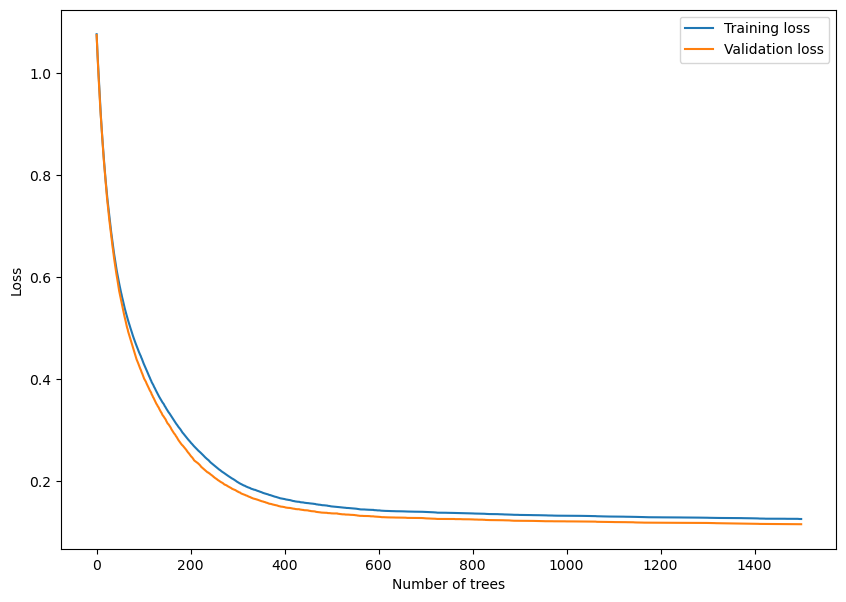

In [17]:
results = xgboost.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
#plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [21]:
sub['Y_Class'] = preds
sub.to_csv('./t37_XGB_com.csv', index = False)

In [22]:
sub

,PRODUCT_ID,Y_Class
0,TEST_000,1
1,TEST_001,1
2,TEST_002,1
3,TEST_003,1
4,TEST_004,1
...,...,...
305,TEST_305,1
306,TEST_306,1
307,TEST_307,1
308,TEST_308,1


학습용과 테스트용 데이터 세트를 위해 별도의 Dmatrix를 생성

In [9]:
#t7_0.53219 ########성능 0.683 train데이터내에서 train validation test 나눠서
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    test_size=0.2, 
                                                    stratify=train_y, 
                                                    random_state=37)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
dtest_x = xgb.DMatrix(data=test_x)

params = {'max_depth' : 6,
          'eta': 0.04,
          'objective':'multi:softmax',
          'num_class':3,
          'eval_metric':'mlogloss',
          'eval_set': [(X_test, y_test)], #적용이 안 되고 있다고 뜸
          'early_stopping':100 #적용이 안 되고 있다고 뜸
          }
num_rounds = 400

wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params, 
                      dtrain=dtrain, 
                      num_boost_round=num_rounds, 
                      early_stopping_rounds=100, 
                      evals=wlist)

[13:00:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping", "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.05928	eval-mlogloss:1.06846
[1]	train-mlogloss:1.02224	eval-mlogloss:1.03964
[2]	train-mlogloss:0.98753	eval-mlogloss:1.01551
[3]	train-mlogloss:0.95449	eval-mlogloss:0.99104
[4]	train-mlogloss:0.92392	eval-mlogloss:0.96798
[5]	train-mlogloss:0.89469	eval-mlogloss:0.94454
[6]	train-mlogloss:0.86730	eval-mlogloss:0.92149
[7]	train-mlogloss:0.84109	eval-mlogloss:0.90036
[8]	train-mlogloss:0.81629	eval-mlogloss:0.88033
[9]	train-mlogloss:0.79239	eval-mlogloss:0.85956
[10]	train-mlogloss:0.77003	eval-mlog

[154]	train-mlogloss:0.07586	eval-mlogloss:0.53859
[155]	train-mlogloss:0.07515	eval-mlogloss:0.53809
[156]	train-mlogloss:0.07432	eval-mlogloss:0.53885
[157]	train-mlogloss:0.07356	eval-mlogloss:0.53911
[158]	train-mlogloss:0.07286	eval-mlogloss:0.53812
[159]	train-mlogloss:0.07214	eval-mlogloss:0.53908
[160]	train-mlogloss:0.07149	eval-mlogloss:0.53970
[161]	train-mlogloss:0.07085	eval-mlogloss:0.53975
[162]	train-mlogloss:0.07019	eval-mlogloss:0.53901
[163]	train-mlogloss:0.06951	eval-mlogloss:0.54001
[164]	train-mlogloss:0.06887	eval-mlogloss:0.53961
[165]	train-mlogloss:0.06811	eval-mlogloss:0.53860
[166]	train-mlogloss:0.06752	eval-mlogloss:0.53814
[167]	train-mlogloss:0.06689	eval-mlogloss:0.53932
[168]	train-mlogloss:0.06617	eval-mlogloss:0.53933
[169]	train-mlogloss:0.06552	eval-mlogloss:0.53895
[170]	train-mlogloss:0.06484	eval-mlogloss:0.54014
[171]	train-mlogloss:0.06418	eval-mlogloss:0.54057
[172]	train-mlogloss:0.06358	eval-mlogloss:0.54042
[173]	train-mlogloss:0.06300	ev

In [10]:
print(xgb_model.best_iteration)
print(xgb_model.best_ntree_limit)
print(xgb_model.best_score)

137
138
0.5321924893185497


In [28]:
pred_probs = xgb_model.predict(dtest_x, ntree_limit=xgb_model.best_ntree_limit)
preds = np.round(pred_probs).astype(int)
sub['Y_Class'] = preds
sub.to_csv('./t30_XGB_Dmatrix_Earlystopping_eta004_testsize01.csv', index = False)

In [12]:
#모델 저장
with open('model_XGB_0683.pickle','wb') as fw:
    pickle.dump(xgb_model, fw)